In [255]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from functools import reduce
import altair as alt
import xarray as xr

# Figure 2

In [274]:
df_mean = pd.read_csv('MAIAC_PM_TOT_daily_regrid_001_NEUS_SIP_Model_flex_KAPM_clear_land_adj2011_daily_time_series.csv', 
                      parse_dates=['Date'])

In [276]:
df_mean = df_mean.set_index('Date')

In [277]:
r_all = []
var_uni = ['PM_Relation','MAIAC_AOD']

# df_roll = df_mean.rolling('10D').mean()

df_mean.loc[(df_mean.index.month == 12) | (df_mean.index.month == 1) | (df_mean.index.month == 2),'season'] = 0
df_mean.loc[(df_mean.index.month == 3) | (df_mean.index.month == 4) | (df_mean.index.month == 5),'season'] = 1
df_mean.loc[(df_mean.index.month == 6) | (df_mean.index.month == 7) | (df_mean.index.month == 8),'season'] = 2
df_mean.loc[(df_mean.index.month == 9) | (df_mean.index.month == 10) | (df_mean.index.month == 11),'season'] = 3

for iv in var_uni:
    for iseason in range(0,4):
        df_mean_sub = df_mean[df_mean.season == iseason]
        x_a = df_mean_sub[iv]
    #     x = sm.add_constant(x)
        y_a = df_mean_sub['MAIAC_PM']
        x= x_a[np.isfinite(x_a) & np.isfinite(y_a)]
        y= y_a[np.isfinite(x_a) & np.isfinite(y_a)]
        results = sm.OLS(y,sm.add_constant(x)).fit()
        r = "{:.2f}".format(results.rsquared**0.5)
   
        r_all.append(r)


In [278]:
for iv in var_uni:
    df_mean_sub = df_mean
    x_a = df_mean_sub[iv]
    y_a = df_mean_sub['MAIAC_PM']
    x= x_a[np.isfinite(x_a) & np.isfinite(y_a)]
    y= y_a[np.isfinite(x_a) & np.isfinite(y_a)]
    results = sm.OLS(y,sm.add_constant(x)).fit()
    r = "{:.2f}".format(results.rsquared**0.5)
    r_all.append(r)


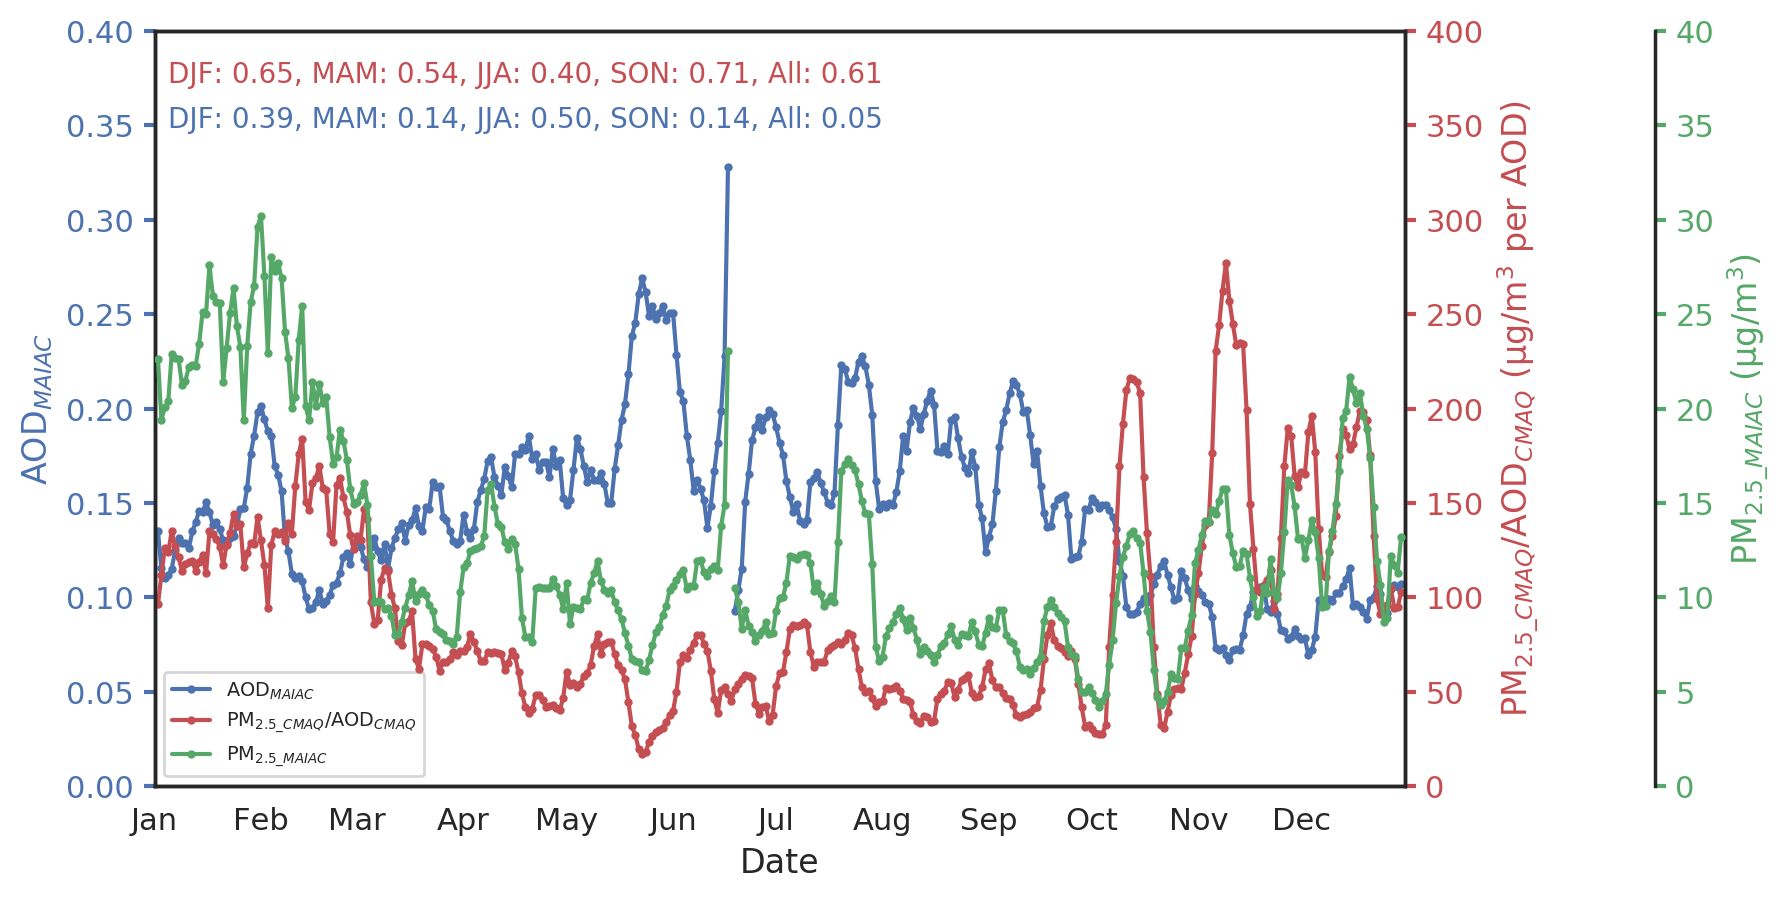

In [279]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

# import matplotlib.dates as mdates

# scatter plot
from matplotlib.dates import DateFormatter

fig, host = plt.subplots(figsize = (10,5), dpi = 200)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

# p1, = df_mean['MAIAC_AOD'].rolling(10).mean().plot(ax = host)
# # ax2 = ax.twinx()
# p2, = df_mean['PM_Relation'].rolling(10).mean().plot(ax = par1, color = 'g')

# # ax3 = ax2.twinx()
# pe, = df_mean['MAIAC_PM'].rolling(10).mean().plot(ax = par1, color = 'r')

time_index_new = pd.date_range(start='1/1/2011', end='12/31/2011')

p1, = host.plot(df_mean['MAIAC_AOD'].rolling('10D').mean()[1:-1].index, df_mean['MAIAC_AOD'].rolling('10D').mean()[1:-1], "b-o", label="AOD$_{MAIAC}$", markersize = 2)
p2, = par1.plot(df_mean['PM_Relation'].rolling('10D').mean()[1:-1].index, df_mean['PM_Relation'].rolling('10D').mean()[1:-1], "r-o", markersize = 2, label="PM$_{2.5\_CMAQ}$/AOD$_{CMAQ}$")
p3, = par2.plot(df_mean['MAIAC_PM'].rolling('10D').mean()[1:-1].index, df_mean['MAIAC_PM'].rolling('10D').mean()[1:-1], "g-o", markersize = 2, label="PM$_{2.5\_MAIAC}$")

xticks = host.get_xticks()
# host.set_xlim(0, 2)
host.set_xlim(pd.Timestamp('2011-01-01'), pd.Timestamp('2011-12-31'))
host.set_ylim(0, 0.4)
par1.set_ylim(0, 400)
par2.set_ylim(0, 40)

host.set_xlabel("Date")
host.set_ylabel("AOD$_{MAIAC}$")
par1.set_ylabel("PM$_{2.5\_CMAQ}$/AOD$_{CMAQ}$ (µg/m$^{3}$ per AOD)")
par2.set_ylabel("PM$_{2.5\_MAIAC}$ (µg/m$^{3}$)")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]


host.text(0.2, 1.64, f'DJF: {r_all[0]}, MAM: {r_all[1]}, JJA: {r_all[2]}, SON: {r_all[3]}, All: {r_all[8]}',transform = ax.transAxes, color = 'r')
host.text(0.2, 1.54, f'DJF: {r_all[4]}, MAM: {r_all[5]}, JJA: {r_all[6]}, SON: {r_all[7]}, All: {r_all[9]}',transform = ax.transAxes, color = 'b')

# ax.text(0.95, 0.04, season,
#          horizontalalignment='right',
#          fontsize=20,
#          transform = ax.transAxes, bbox={'facecolor':'red', 'alpha':0.1, 'pad':10})


host.legend(lines, [l.get_label() for l in lines],loc='lower left',fontsize = 'x-small')

host.xaxis.set_major_formatter(DateFormatter('%b'))

plt.show()

# Figure 3: Evaluation of MAIAC AOD

In [4]:
data_KAPM = pd.read_csv('MAIAC_CMAQ_SIP_AERONET_comparison_daily_all_together_NEUS_three_AOD_algorithms_001flex_KAPM_clear_land_adj_winter_filter.csv')
data_010 = pd.read_csv('MAIAC_CMAQ_SIP_AERONET_comparison_daily_all_together_NEUS_three_AOD_algorithms_010flex_KAPM_clear_land_adj_winter_filter.csv')
data_list = [data_KAPM, data_010]

In [5]:
for data in data_list:
    df = pd.DataFrame({'year': data.year,
                       'month': data.month,
                       'day': data.day})
    data['date'] = pd.to_datetime(df)

In [6]:
for data in data_list:
    data['doy'] = data.date.dt.dayofyear

In [7]:
for data in data_list:
    data['woy'] = (data.doy/7).astype(int)
    data['toy'] = (data.doy/10).astype(int)
    data['foy'] = (data.doy/15).astype(int)
    data.loc[(data.month == 12) | (data.month == 1) | (data.month == 2),'season'] = 0
    data.loc[(data.month == 3) | (data.month == 4) | (data.month == 5),'season'] = 1
    data.loc[(data.month == 6) | (data.month == 7) | (data.month == 8),'season'] = 2
    data.loc[(data.month == 9) | (data.month == 10) | (data.month == 11),'season'] = 3
for data in data_list:
    data.loc[data.season == 0,'winter'] = 'Winter'
    data.loc[data.season != 0,'winter'] = 'Non Winter'   
for data in data_list:
    data.loc[data.season == 2,'summer'] = 'Summer'
    data.loc[data.season != 2,'summer'] = 'Non Summer'       

In [8]:
composite = 'doy'
data = data_KAPM
valid_data = data[(data.AOD_551 > 0) & (data.MAIAC_AOD >0) & (data.MAIAC_AOD/data.AOD_551 <5)]
data_composite = valid_data.groupby([composite,'code']).mean()
data_composite['NMB_AOD'] = (data_composite['MAIAC_AOD']/data_composite['AOD_551']-1)*100.
data_composite['MB_AOD'] = (data_composite['MAIAC_AOD'] - data_composite['AOD_551'])
data_composite.loc[data_composite.season == 0,'winter'] = 'Winter'
data_composite.loc[data_composite.season != 0,'winter'] = 'Non Winter'  
df = data_composite[['NMB_AOD','season']]
df = df.rename(columns = {'NMB_AOD':'Daily 1km','season':'season'})

In [9]:
composite = 'month'
data = data_KAPM
valid_data = data[(data.AOD_551 > 0) & (data.MAIAC_AOD >0) & (data.MAIAC_AOD/data.AOD_551 <5)]
data_composite = valid_data.groupby([composite,'code']).mean()
data_composite['NMB_AOD'] = (data_composite['MAIAC_AOD']/data_composite['AOD_551']-1)*100.
data_composite['MB_AOD'] = (data_composite['MAIAC_AOD'] - data_composite['AOD_551'])
data_composite.loc[data_composite.season == 0,'winter'] = 'Winter'
data_composite.loc[data_composite.season != 0,'winter'] = 'Non Winter'  
df2 = data_composite[['NMB_AOD','season']]
df2 = df2.rename(columns = {'NMB_AOD':'Monthly 1km','season':'season'})

In [10]:
composite = 'month'
data = data_010
valid_data = data[(data.AOD_551 > 0) & (data.MAIAC_AOD >0) & (data.MAIAC_AOD/data.AOD_551 <5)]
data_composite = valid_data.groupby([composite,'code']).mean()
data_composite['NMB_AOD'] = (data_composite['MAIAC_AOD']/data_composite['AOD_551']-1)*100.
data_composite['MB_AOD'] = (data_composite['MAIAC_AOD'] - data_composite['AOD_551'])
data_composite.loc[data_composite.season == 0,'winter'] = 'Winter'
data_composite.loc[data_composite.season != 0,'winter'] = 'Non Winter'  
df3 = data_composite[['NMB_AOD','season']]
df3 = df3.rename(columns = {'NMB_AOD':'Daily 10km','season':'season'})

In [11]:
frames = [df, df2, df3]
df_all = pd.concat(frames)
tidy_NMB = (
    df_all.set_index('season')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)

In [12]:
composite = 'doy'
data = data_KAPM
valid_data = data[(data.AOD_551 > 0) & (data.MAIAC_AOD >0) & (data.MAIAC_AOD/data.AOD_551 <5)]
data_composite = valid_data.groupby([composite,'code']).mean()
data_composite['AERONET_PM_MB'] = data_composite['MAIAC_AOD']*data_composite['PM_AOD_Relation'] - data_composite['AOD_551']*data_composite['PM_AOD_Relation']
data_composite['NMB_AOD'] = (data_composite['MAIAC_AOD']/data_composite['AOD_551']-1)
data_composite['MB_AOD'] = (data_composite['MAIAC_AOD'] - data_composite['AOD_551'])
data_composite.loc[data_composite.season == 0,'winter'] = 'Winter'
data_composite.loc[data_composite.season != 0,'winter'] = 'Non Winter'  
df = data_composite[['AERONET_PM_MB','season']]
df = df.rename(columns = {'AERONET_PM_MB':'Daily 1km','season':'season'})

In [13]:
composite = 'month'
data = data_KAPM
valid_data = data[(data.AOD_551 > 0) & (data.MAIAC_AOD >0) & (data.MAIAC_AOD/data.AOD_551 <5)]
data_composite = valid_data.groupby([composite,'code']).mean()
data_composite['AERONET_PM_MB'] = data_composite['MAIAC_AOD']*data_composite['PM_AOD_Relation'] - data_composite['AOD_551']*data_composite['PM_AOD_Relation']
data_composite['NMB_AOD'] = (data_composite['MAIAC_AOD']/data_composite['AOD_551']-1)
data_composite['MB_AOD'] = (data_composite['MAIAC_AOD'] - data_composite['AOD_551'])
data_composite.loc[data_composite.season == 0,'winter'] = 'Winter'
data_composite.loc[data_composite.season != 0,'winter'] = 'Non Winter'  
df2 = data_composite[['AERONET_PM_MB','season']]
df2 = df2.rename(columns = {'AERONET_PM_MB':'Monthly 1km','season':'season'})

In [14]:
composite = 'month'
data = data_010
valid_data = data[(data.AOD_551 > 0) & (data.MAIAC_AOD >0) & (data.MAIAC_AOD/data.AOD_551 <5)]
data_composite = valid_data.groupby([composite,'code']).mean()
data_composite['AERONET_PM_MB'] = data_composite['MAIAC_AOD']*data_composite['PM_AOD_Relation'] - data_composite['AOD_551']*data_composite['PM_AOD_Relation']
data_composite['NMB_AOD'] = (data_composite['MAIAC_AOD']/data_composite['AOD_551']-1)
data_composite['MB_AOD'] = (data_composite['MAIAC_AOD'] - data_composite['AOD_551'])
data_composite.loc[data_composite.season == 0,'winter'] = 'Winter'
data_composite.loc[data_composite.season != 0,'winter'] = 'Non Winter'  
df3 = data_composite[['AERONET_PM_MB','season']]
df3 = df3.rename(columns = {'AERONET_PM_MB':'Daily 10km','season':'season'})

In [15]:
frames = [df, df2, df3]
df_all = pd.concat(frames)
tidy_PM = (
    df_all.set_index('season')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)

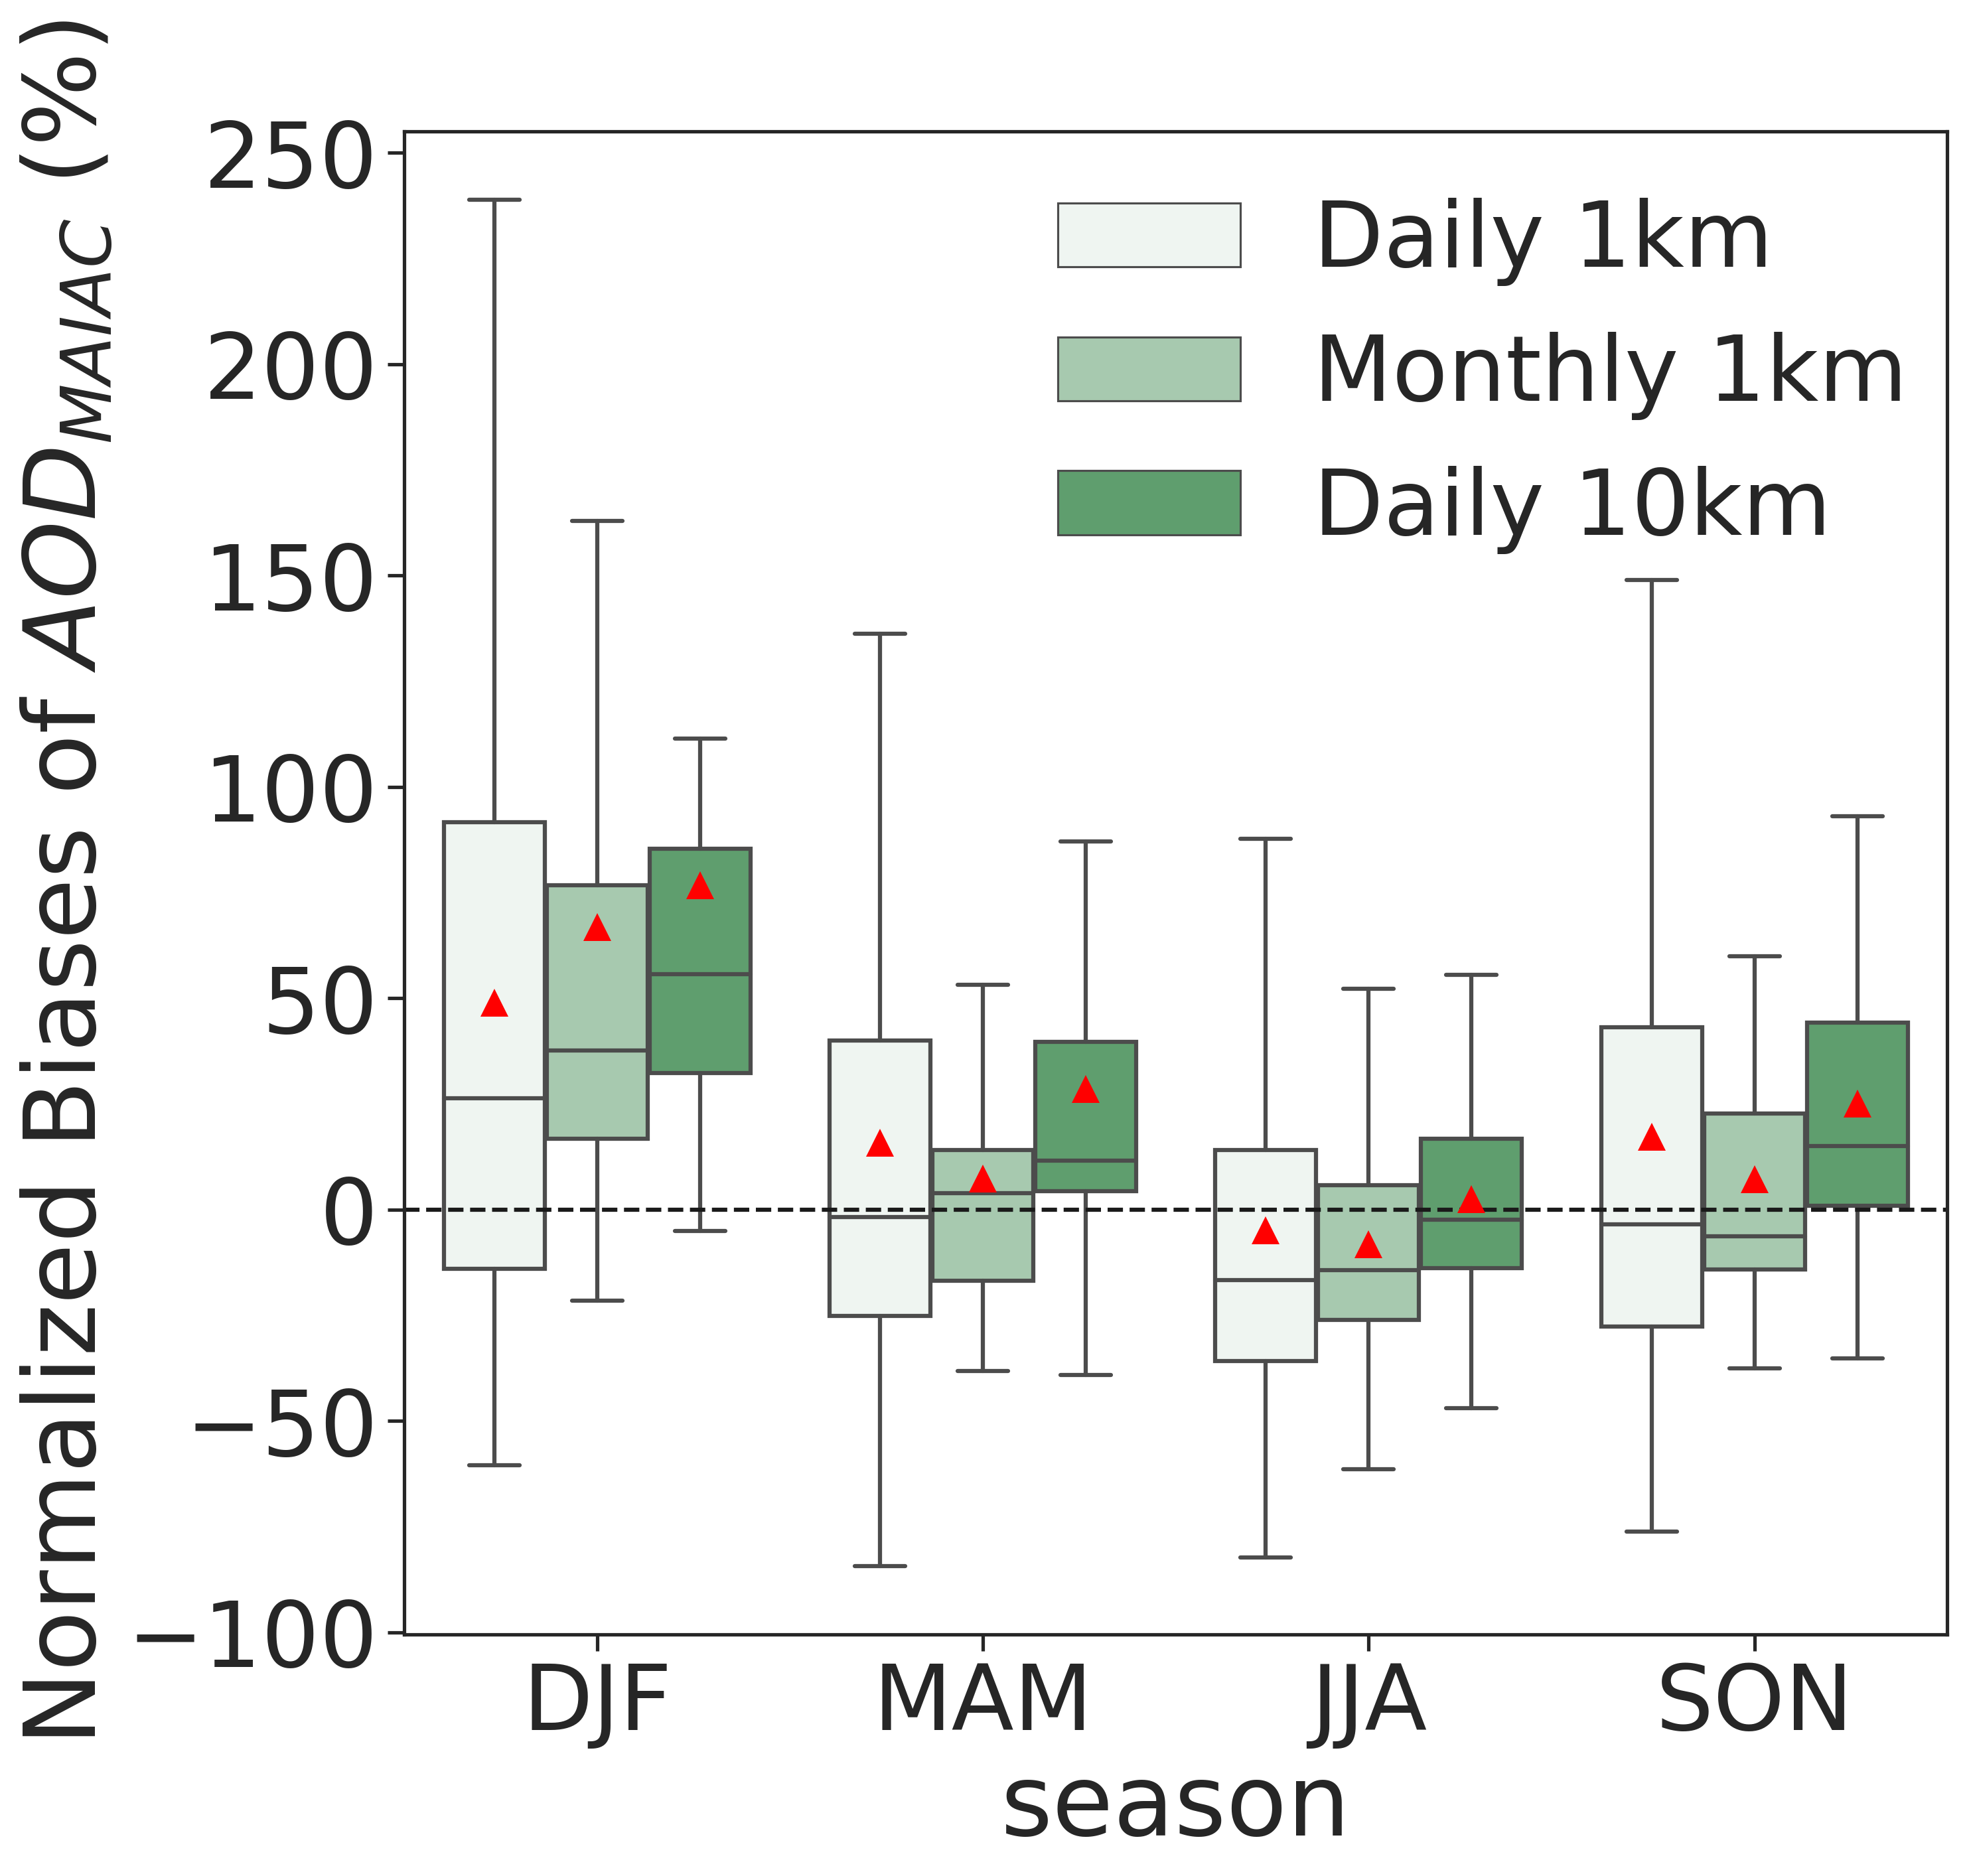

In [26]:
meanpointprops = dict( markerfacecolor='red', markersize=10, markeredgecolor = 'None')

sns.set(color_codes=True, font_scale = 3)
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
fig, ax = plt.subplots(1,1,figsize=(10, 10), dpi = 300)
sns.boxplot(x = 'season', y = 'Value',hue = 'Variable', data =tidy_NMB, color="g", ax = ax, showfliers=False,showmeans=True,meanprops = meanpointprops)
ax.axhline(0, color='k',linestyle = '--',linewidth = 1.5)
# ax.set_title('Normalized Errors of $AOD_{MAIAC}$')
ax.set_ylabel('Normalized Biases of $AOD_{MAIAC}$ (%)')
ax.legend(bbox_to_anchor=(0.4, 0.98), loc=2, borderaxespad=0., frameon = False)
labels = ['DJF','MAM','JJA','SON']
ax.set_xticklabels(labels)
fig.savefig('fig01.pdf')

# Figure 4: Evaluation of modeled PM/AOD relationship

In [29]:
data_KAPM = pd.read_csv('CMAQ_SIP_AERONET_AQS_daily_comparison_sampled_coincidence_reduced_flex_KAPM_clear001.csv')
data_HGF = pd.read_csv('CMAQ_SIP_AERONET_AQS_daily_comparison_sampled_coincidence_reduced_flex_HGF_clear001.csv')
data_list = [data_KAPM, data_HGF]

In [30]:
for data in data_list:
    df = pd.DataFrame({'year': data.year,
                       'month': data.month,
                       'day': data.day})
    data['date'] = pd.to_datetime(df)

In [31]:
for data in data_list:
    data['doy'] = data.date.dt.dayofyear
    data['MAIAC_PM'] = data.MAIAC_AOD[(data.MAIAC_AOD != -9999)] *data.CMAQ_Relation[(data.MAIAC_AOD != -9999)]
    data['CMAQ_PM'] = data.CMAQ_AOD[(data.CMAQ_AOD != -9999)] *data.CMAQ_Relation[(data.CMAQ_AOD != -9999)]

In [32]:
for data in data_list:
    data['woy'] = (data.doy/7).astype(int)
    data['toy'] = (data.doy/10).astype(int)
    data['foy'] = (data.doy/15).astype(int)
    data.loc[(data.month == 12) | (data.month == 1) | (data.month == 2),'season'] = 0
    data.loc[(data.month == 3) | (data.month == 4) | (data.month == 5),'season'] = 1
    data.loc[(data.month == 6) | (data.month == 7) | (data.month == 8),'season'] = 2
    data.loc[(data.month == 9) | (data.month == 10) | (data.month == 11),'season'] = 3 

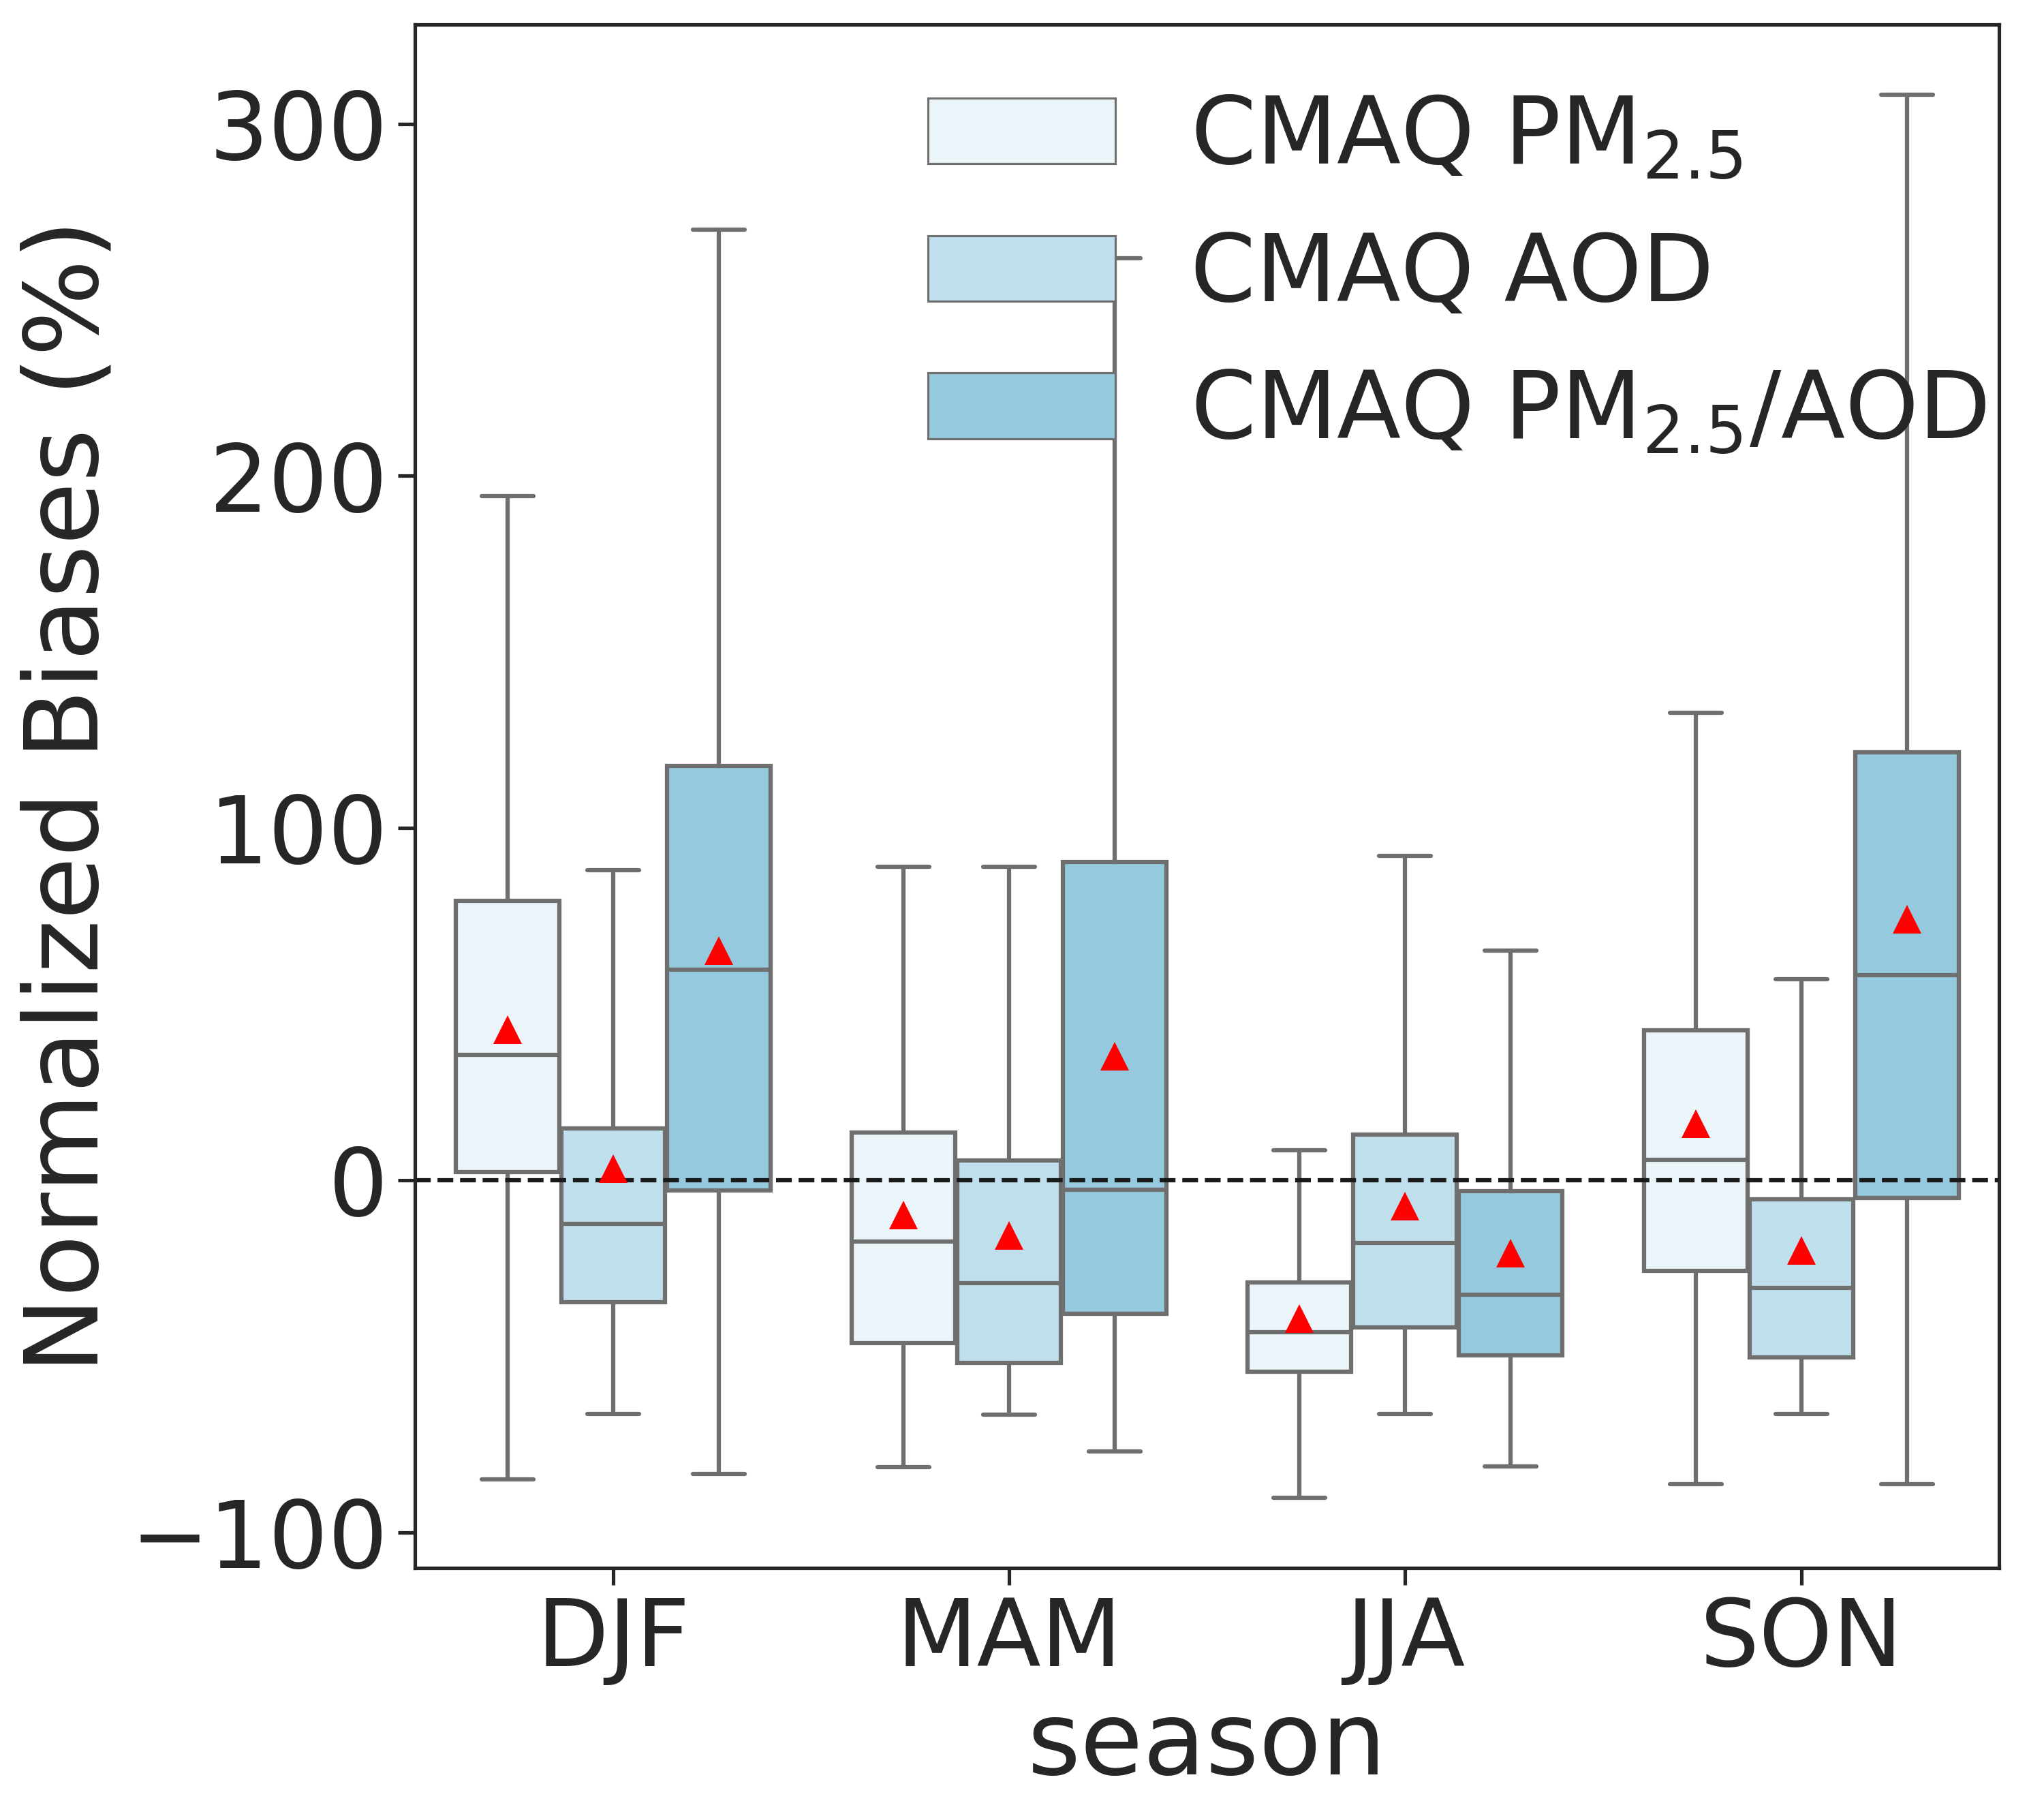

In [38]:
# data_str_NMB = ['NMB_PM','NMB_AOD','NMB_Rel']
sns.set(color_codes=True, font_scale = 3)
sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})

y_label_array = ['CMAQ PM$_{2.5}$','CMAQ AOD','CMAQ PM$_{2.5}$/AOD Relation']

data = data_KAPM
valid_data = data[(data.Obs_Relation != -9999) & (data.AERONET_AOD != -9999) & (data.AQS_PM != -9999) & (data.CMAQ_AOD / data.AERONET_AOD <3) & (data.CMAQ_PM / data.AQS_PM <3) & (data.AERONET_AOD / data.CMAQ_AOD <3) ]

data_composite = valid_data.groupby(['doy','AERONET_Site']).mean()
data_composite.season = data_composite.season.astype('int')
data_composite.month = data_composite.month.astype('int')

data_composite['NMB_Rel'] = (data_composite['CMAQ_Relation']/data_composite['Obs_Relation']-1)*100.
data_composite['NMB_AOD'] = (data_composite['CMAQ_AOD']/data_composite['AERONET_AOD']-1)*100.
data_composite['NMB_PM'] = (data_composite['CMAQ_PM']/data_composite['AQS_PM']-1)*100.

data_composite['MB_Rel'] = (data_composite['CMAQ_Relation'] - data_composite['Obs_Relation'])
data_composite['MB_AOD'] = (data_composite['CMAQ_AOD'] - data_composite['AERONET_AOD'])
data_composite['MB_PM'] = (data_composite['CMAQ_PM'] - data_composite['AQS_PM'])




df = data_composite[['NMB_PM','NMB_AOD','NMB_Rel','season']]
df = df.rename(columns = {'NMB_PM':'CMAQ PM$_{2.5}$', 'NMB_AOD':'CMAQ AOD','NMB_Rel':'CMAQ PM$_{2.5}$/AOD','season':'season'})

# frames = [df, df2, df3]
# df_all = pd.concat(df)
tidy_NMB = (
    df.set_index('season')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)

fig, ax = plt.subplots(1,1,figsize=(10, 10), dpi = 300)
sns.boxplot(x = 'season', y = 'Value',hue = 'Variable', data =tidy_NMB, color="skyblue", ax = ax, showfliers=False,showmeans=True,meanprops = meanpointprops)
ax.axhline(0, color='k',linestyle = '--',linewidth = 1.5)
# ax.set_title('Normalized Errors of $AOD_{MAIAC}$')
ax.set_ylabel('Normalized Biases (%)')
ax.legend(bbox_to_anchor=(0.3, 0.98), loc=2, borderaxespad=0., frameon = False)
labels = ['DJF','MAM','JJA','SON']
ax.set_xticklabels(labels)
# ax.text(0.95, 0.05,'a)', ha='center', va='center', transform=ax.transAxes)
fig.savefig('fig03.pdf')

# Figure 5a

In [39]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [40]:
data_KAPM = pd.read_csv('CMAQ_SIP_AERONET_AQS_daily_comparison_sampled_coincidence_reduced_flex_KAPM_clear001.csv')
data_HGF = pd.read_csv('CMAQ_SIP_AERONET_AQS_daily_comparison_sampled_coincidence_reduced_flex_HGF_clear001.csv')
data_list = [data_KAPM, data_HGF]

In [41]:
for data in data_list:
    df = pd.DataFrame({'year': data.year,
                       'month': data.month,
                       'day': data.day})
    data['date'] = pd.to_datetime(df)

In [42]:
for data in data_list:
    data['doy'] = data.date.dt.dayofyear
    data['MAIAC_PM'] = data.MAIAC_AOD[(data.MAIAC_AOD != -9999)] *data.CMAQ_Relation[(data.MAIAC_AOD != -9999)]
    data['CMAQ_PM'] = data.CMAQ_AOD[(data.CMAQ_AOD != -9999)] *data.CMAQ_Relation[(data.CMAQ_AOD != -9999)]

In [43]:
for data in data_list:
    data['woy'] = (data.doy/7).astype(int)
    data['toy'] = (data.doy/10).astype(int)
    data['foy'] = (data.doy/15).astype(int)
    data.loc[(data.month == 12) | (data.month == 1) | (data.month == 2),'season'] = 0
    data.loc[(data.month == 3) | (data.month == 4) | (data.month == 5),'season'] = 1
    data.loc[(data.month == 6) | (data.month == 7) | (data.month == 8),'season'] = 2
    data.loc[(data.month == 9) | (data.month == 10) | (data.month == 11),'season'] = 3 

[Text(0,0,'DJF'), Text(0,0,'MAM'), Text(0,0,'JJA'), Text(0,0,'SON')]

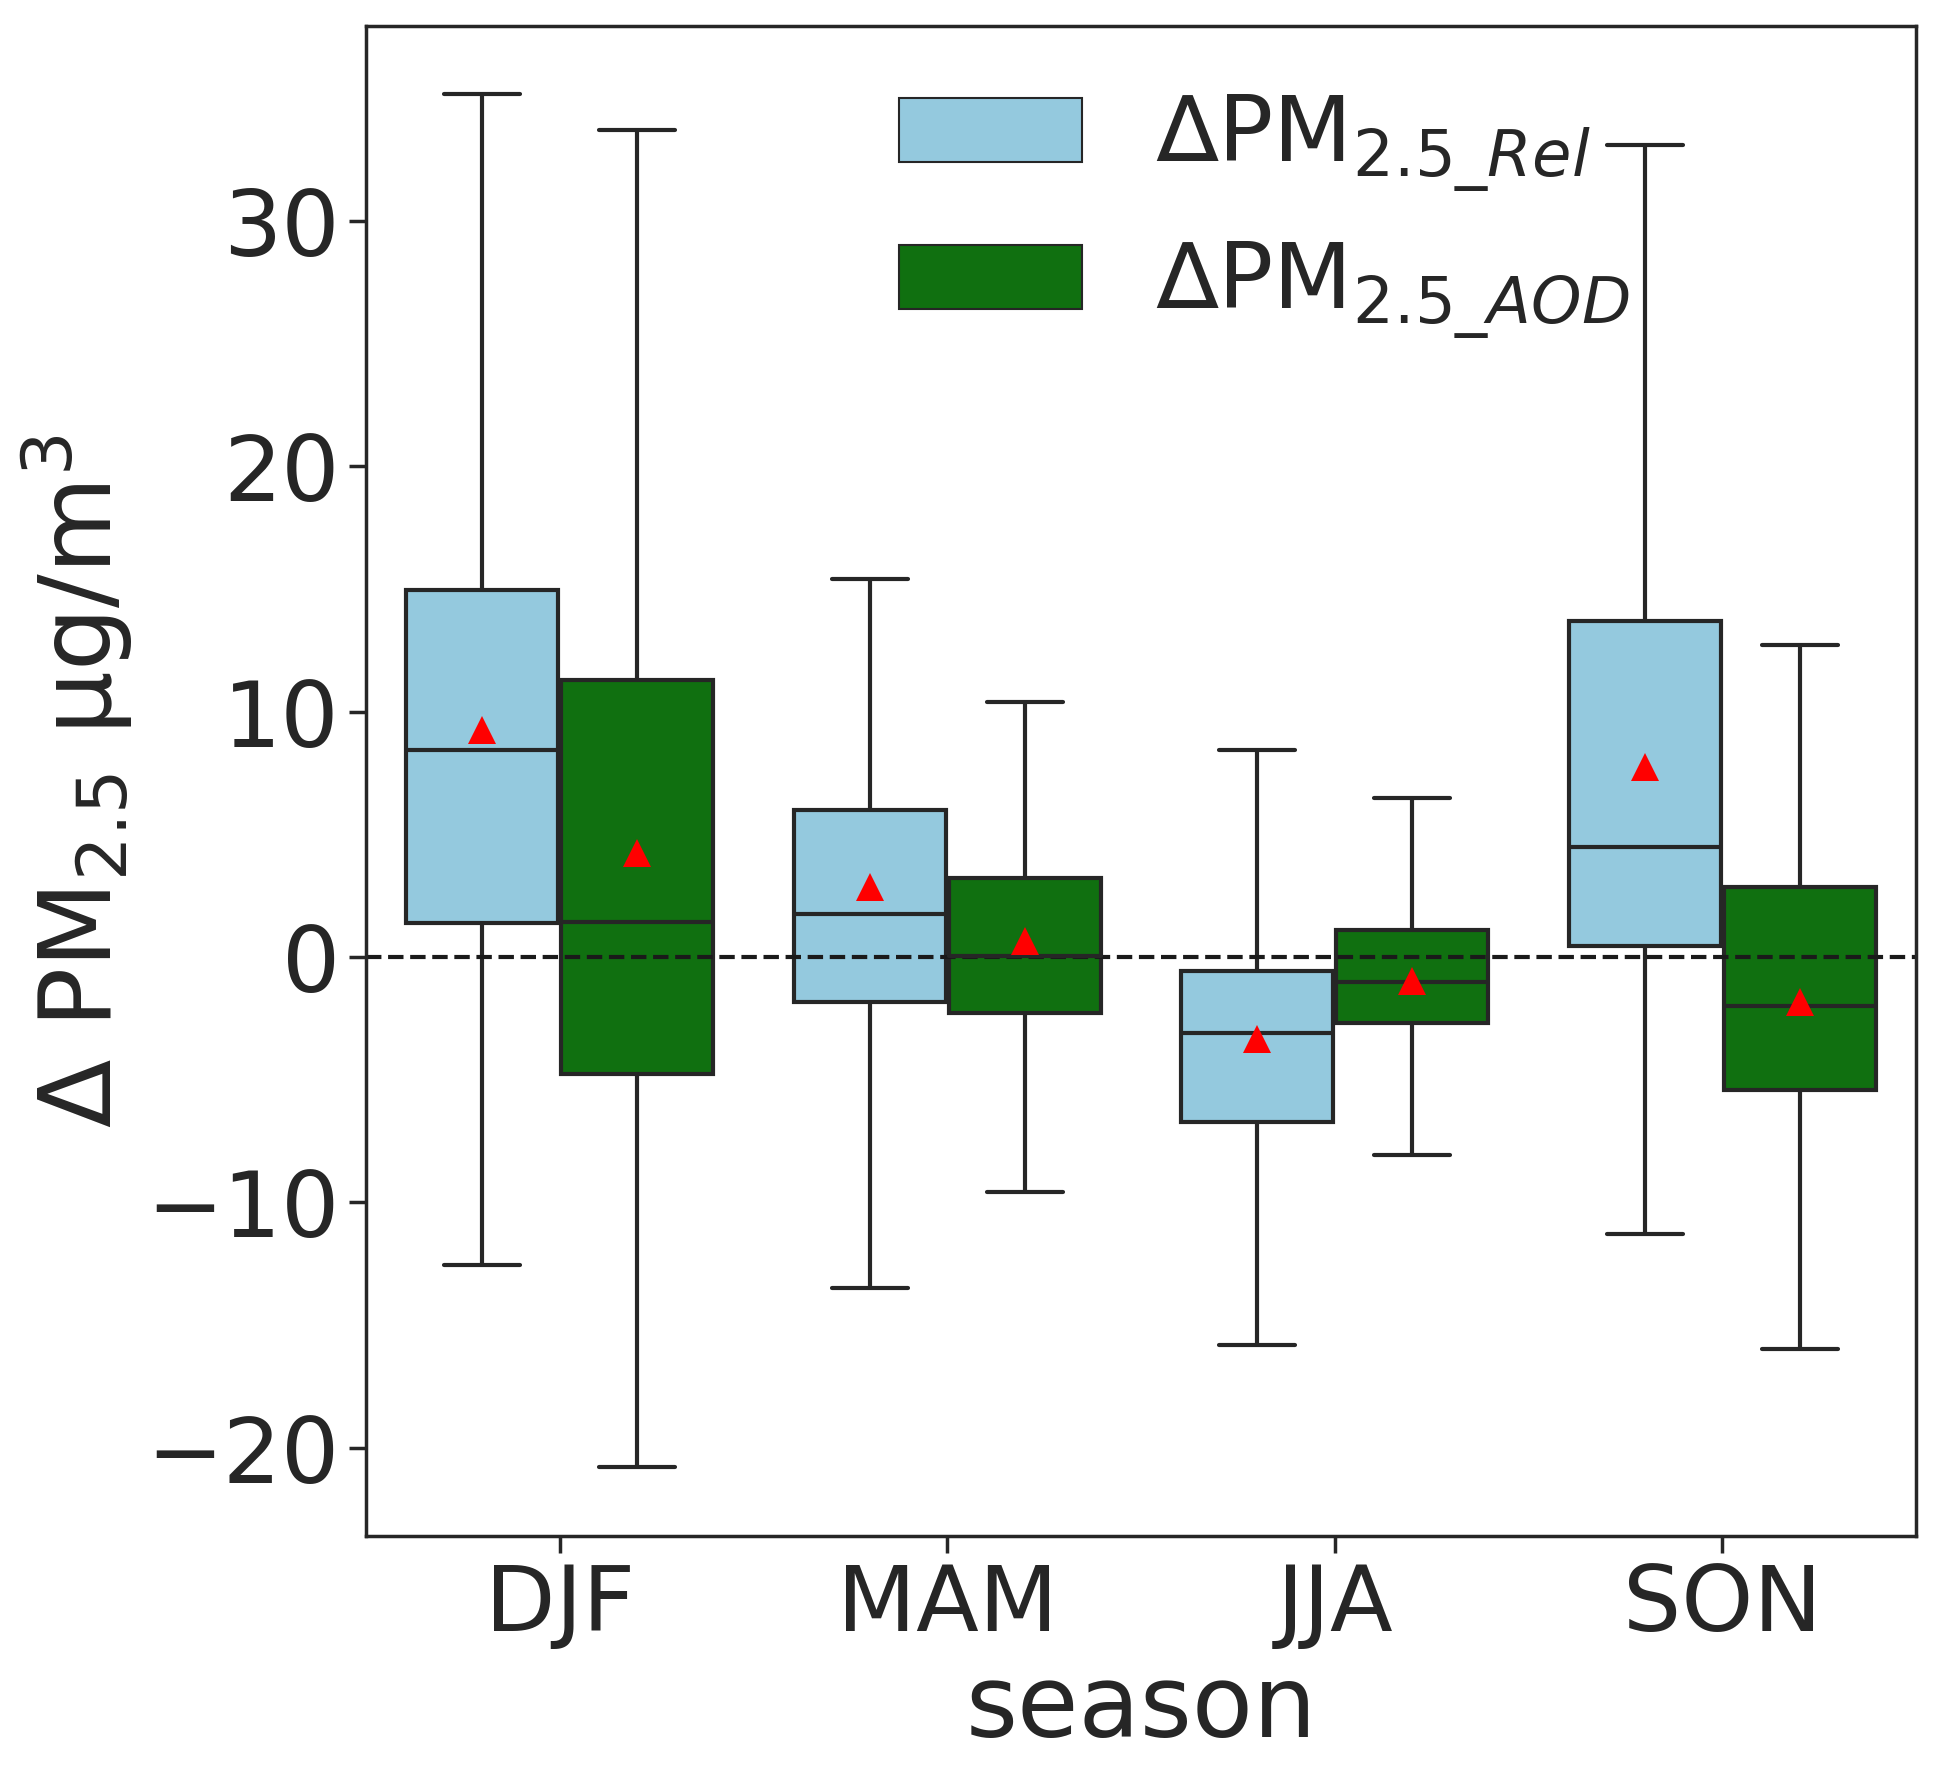

In [45]:
data = data_KAPM
valid_data = data[(data.Obs_Relation != -9999) & (data.AERONET_AOD != -9999) & (data.AQS_PM != -9999) & (data.MAIAC_AOD != -9999) & (data.MAIAC_AOD/data.AERONET_AOD <5)& (data.CMAQ_AOD / data.AERONET_AOD <3) & (data.CMAQ_PM / data.AQS_PM <3) & (data.AERONET_AOD / data.CMAQ_AOD <3) ]
data_composite = valid_data.groupby(['doy','AERONET_Site']).mean()
data_composite.season = data_composite.season.astype('int')
data_composite.month = data_composite.month.astype('int')
data_composite['MAIAC_PM_AERONET'] = data_composite['MAIAC_AOD']*data_composite['CMAQ_PM']/data_composite['AERONET_AOD']
data_composite['MAIAC_PM_AQS'] = data_composite['MAIAC_AOD']*data_composite['AQS_PM']/data_composite['CMAQ_AOD']
data_composite['MAIAC_PM_Obs'] = data_composite['MAIAC_AOD']*data_composite['AQS_PM']/data_composite['AERONET_AOD']
data_composite['AERONET_PM'] = data_composite['AERONET_AOD']*data_composite['CMAQ_PM']/data_composite['CMAQ_AOD']

data_composite['MB_PM_AERONET'] = -1* (data_composite['MAIAC_PM_AERONET'] - data_composite['MAIAC_PM'])
data_composite['MB_PM_AQS'] = -1*(data_composite['MAIAC_PM_AQS'] - data_composite['MAIAC_PM'])
data_composite['MB_PM_Obs'] = -1*(data_composite['MAIAC_PM_Obs'] - data_composite['MAIAC_PM'])
data_composite['MB_AERONET_PM'] = -1*(data_composite['AERONET_PM'] - data_composite['MAIAC_PM'])
data_composite['MB_PM_ori'] = -1*(data_composite['AQS_PM'] - data_composite['MAIAC_PM'])

df = data_composite[['MB_PM_Obs','MB_AERONET_PM','season']]
df = df.rename(columns = {'MB_AERONET_PM':'∆PM$_{2.5\_AOD}$','season':'season','MB_PM_Obs':'∆PM$_{2.5\_Rel}$'})


tidy_PM = (
    df.set_index('season')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)

sns.set(color_codes=True, font_scale = 3)
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
my_pal = {"∆PM$_{2.5\_Rel}$": "skyblue", "∆PM$_{2.5\_AOD}$": "green"}
meanpointprops = dict( markerfacecolor='red', markersize=10, markeredgecolor = 'None')

fig, ax = plt.subplots(figsize=(10, 10), dpi = 200)
sns.boxplot(x = 'season', y = 'Value',hue = 'Variable', data =tidy_PM, palette=my_pal, ax = ax, showfliers=False, showmeans = True,meanprops = meanpointprops)
fig.subplots_adjust(hspace=0.3, wspace = 0.3)
ax.axhline(0, color='k',linestyle = '--',linewidth = 1.5)
# ax.set_title('Errors of AOD$_{MAIAC}$ vs. PM$_{2.5}$/AOD')
ax.set_ylabel('$\Delta$ PM$_{2.5}$ µg/m$^{3}$')
ax.legend(bbox_to_anchor=(0.32, 0.98), loc=2, borderaxespad=0., frameon = False)
labels = ['DJF','MAM','JJA','SON']
ax.set_xticklabels(labels)

In [46]:
r_all = []
var_uni = ['MB_PM_Obs','MB_AERONET_PM']
for iv in var_uni:
    for iseason in range(0,4):
        data_sub = data_composite[data_composite.season == iseason]
        x = data_sub[iv]
    #     x = sm.add_constant(x)
        y = data_sub['MB_PM_ori']
        results = sm.OLS(y,sm.add_constant(x)).fit()
        r_all.append(results.rsquared**0.5)



In [47]:
r_all

[0.8115882471260093,
 0.87301932641159785,
 0.48915552380129673,
 0.91398252683911052,
 0.72066470214860823,
 0.61433870422513315,
 0.47636343916265556,
 0.36274745131142827]

In [48]:
r_rel = r_all[0:4]
r_aod = r_all[4:9]

/home/xjin/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


[Text(0,0,'DJF'), Text(0,0,'MAM'), Text(0,0,'JJA'), Text(0,0,'SON')]

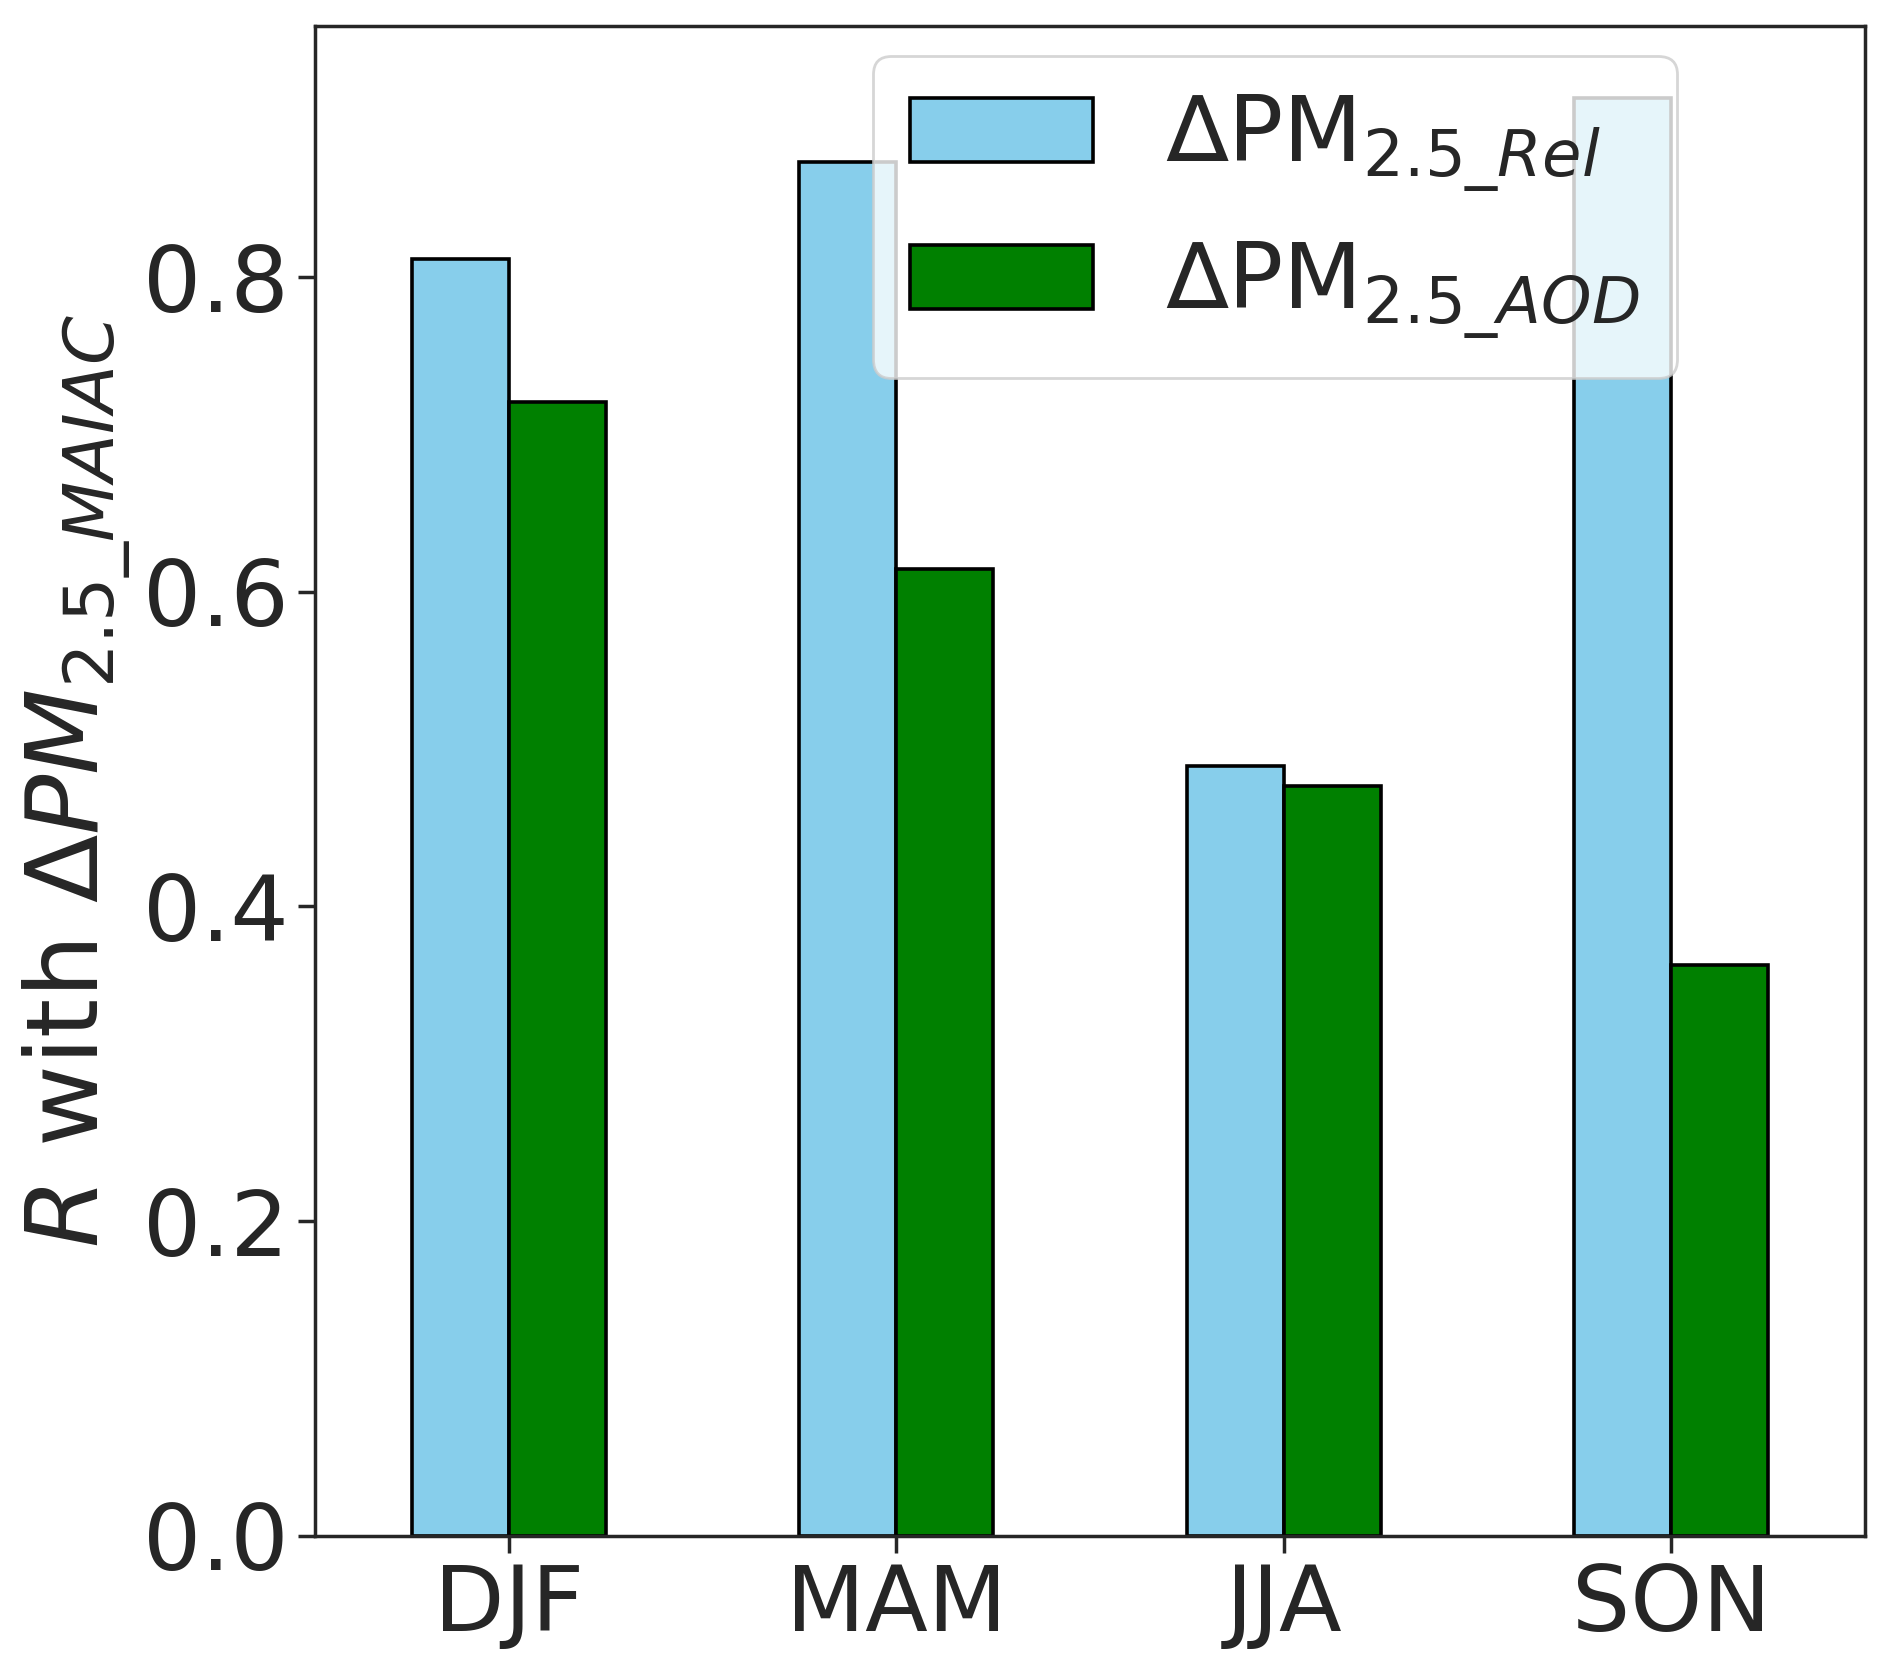

In [49]:
value = r_rel
value_2 = r_aod
sns.set(color_codes=True, font_scale = 3)
color_arr = sns.color_palette("Set2", 8)
color_arr_sub = color_arr[2:8]

# df_pm_all[var_name].boxplot()
# sns.set(color_codes=True, font_scale = 1.18)
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
fig, ax = plt.subplots(figsize=(10, 10), dpi = 200)
df = pd.DataFrame({'Var':['DJF','MAM','JJA','DJF'], '∆PM$_{2.5\_Rel}$':value, '∆PM$_{2.5\_AOD}$': value_2})
df.plot.bar(ax = ax, x='Var', y=['∆PM$_{2.5\_Rel}$', '∆PM$_{2.5\_AOD}$'], rot=0, color = ['skyblue','green'],edgecolor = ['black','black','black','black'],linewidth= 1.3)
ax.set_xlabel('')
ax.set_ylabel('$R$ with $\Delta PM_{2.5\_MAIAC}$')
ax.legend(bbox_to_anchor=(0.36, 0.98), loc=2, borderaxespad=0.)
labels = ['DJF','MAM','JJA','SON']
ax.set_xticklabels(labels)


# Figure 6

# Figure 6b

In [52]:
species_list = ["Sulfate","Nitrate","OC","EC","Fine_Soil","Ammonium"]
data_list = []
data_all_list = []
for ind_a, species in enumerate(species_list):
    data = pd.read_csv('CMAQ_SIP_PM25_speciation_compare_with_AQS_NEUS_daily_with_species_AOD'+species+'.csv')
    df = pd.DataFrame({'year': data.year,
                       'month': data.month,
                       'day': data.day})
    data_all_list.append(data)
    data['date'] = pd.to_datetime(df)
    data_sub = data[['code','year','month','day','CMAQ_'+species,'CMAQ_AOD' +species ,'CMAQ_AOD_C' +species,'AQS_' +species]]
    data_list.append(data_sub)

In [53]:
df_merged = pd.merge(data_list[0],data_list[1],on=['code','year','month','day'],
                                            how='outer',validate="one_to_one")

In [54]:
for ind_a in range(2, len(species_list)):
    df_merged = pd.merge(df_merged,data_list[ind_a],on=['code','year','month','day'],
                                                how='outer',validate="one_to_one")

In [55]:
data = data_all_list[0]
data_new = data[['code','year','month','day','RH','BOXH','MAIAC_AOD','CMAQ_Relation','CMAQ_AOD','CMAQ_AOD_Sampled','PM_AOD_surface','AOD_surface_column']]
df_merged_all = pd.merge(df_merged,data_new,on=['code','year','month','day'],
                                                how='outer',validate="one_to_one")

In [56]:
mask = ((df_merged_all != -9999.) & (df_merged_all >0) & (df_merged_all.notna()))
valid_data = df_merged_all.where(mask)
CMAQ_ind = ['CMAQ_' + s  for s in species_list]

In [57]:
valid_data['CMAQ_SNA'] = valid_data['CMAQ_Sulfate'] + valid_data['CMAQ_Nitrate'] + valid_data['CMAQ_Ammonium'].fillna(0)
valid_data['AQS_SNA'] = valid_data['AQS_Sulfate'] + valid_data['AQS_Nitrate'] + valid_data['AQS_Ammonium'].fillna(0)
valid_data['CMAQ_AOD_CSNA'] = valid_data['CMAQ_AOD_CSulfate'] 

In [58]:
# species_list = ["SNA","Sulfate","Nitrate","OC","EC","Fine_Soil","Sea_Salt","Ammonium"]

species_list_CMAQ = ["SNA","OC","EC","Fine_Soil"]
species_list = ["SNA","OC"]
CMAQ_ind = ['CMAQ_' + s  for s in species_list]
CMAQ_AOD_C_ind = ['CMAQ_AOD_C' + s  for s in species_list]

CMAQ_ind_all = ['CMAQ_' + s  for s in species_list_CMAQ]
CMAQ_AOD_C_ind_all = ['CMAQ_AOD_C' + s  for s in species_list_CMAQ]
AQS_in_all = ['AQS_' + s  for s in species_list_CMAQ]

AQS_in = ['AQS_' + s  for s in species_list]
AQS_PM_sum = valid_data[AQS_in].sum(axis=1)
CMAQ_PM_sum = valid_data[CMAQ_ind].sum(axis=1)
CMAQ_AOD_sum = valid_data[CMAQ_AOD_C_ind].sum(axis=1)

CMAQ_AOD_sum_all = valid_data[CMAQ_AOD_C_ind_all].sum(axis=1)
CMAQ_PM_sum_all = valid_data[CMAQ_ind_all].sum(axis=1)

for ind_a, species in enumerate(species_list):
    valid_data['AQS_fra_'+species] = valid_data[AQS_in[ind_a]]/AQS_PM_sum
    valid_data['CMAQ_fra_'+species] = valid_data[CMAQ_ind[ind_a]]/CMAQ_PM_sum
    valid_data['CMAQ_redistr_'+species] = CMAQ_PM_sum*valid_data['AQS_fra_'+species]
    valid_data['CMAQ_AOD_redistr_'+species] = valid_data['CMAQ_redistr_'+species]* valid_data['CMAQ_AOD_C'+species]/valid_data['CMAQ_'+species]
CMAQ_AOD_new = ['CMAQ_AOD_redistr_' + s  for s in species_list]
valid_data['CMAQ_AOD_total_old'] = valid_data[CMAQ_AOD_C_ind_all].sum(axis=1)
valid_data['CMAQ_AOD_total_new'] = valid_data[CMAQ_AOD_new].sum(axis=1) + valid_data[CMAQ_AOD_C_ind_all].sum(axis=1) - valid_data[CMAQ_AOD_C_ind].sum(axis=1)
valid_data['CMAQ_PM_AOD_Rel_new'] = CMAQ_PM_sum/valid_data['CMAQ_AOD_total_new']
valid_data['CMAQ_PM_AOD_Rel_old'] = CMAQ_PM_sum/CMAQ_AOD_sum_all
valid_data.loc[(valid_data.MAIAC_AOD>0),'MAIAC_AOD_new'] = valid_data.MAIAC_AOD
valid_data['MAIAC_PM_AOD_Rel_old'] = valid_data['CMAQ_PM_AOD_Rel_old']*valid_data['MAIAC_AOD_new']
valid_data['MAIAC_PM_AOD_Rel_new'] = valid_data['CMAQ_PM_AOD_Rel_new']*valid_data['MAIAC_AOD_new']
valid_data['AQS_PM_sum'] = valid_data[AQS_in_all].sum(axis=1)

In [59]:
species_list = ["SNA","OC"]
CMAQ_ind = ['CMAQ_' + s  for s in species_list]
CMAQ_AOD_C_ind = ['CMAQ_AOD_C' + s  for s in species_list]
AQS_in = ['AQS_' + s  for s in species_list]

valid_data.loc[(valid_data.month == 12) | (valid_data.month == 1) | (valid_data.month == 2),'season'] = 0
valid_data.loc[(valid_data.month == 3) | (valid_data.month == 4) | (valid_data.month == 5),'season'] = 1
valid_data.loc[(valid_data.month == 6) | (valid_data.month == 7) | (valid_data.month == 8),'season'] = 2
valid_data.loc[(valid_data.month == 9) | (valid_data.month == 10) | (valid_data.month == 11),'season'] = 3 

data_composite = valid_data.groupby(['month']).mean()
d = {}
for species in species_list:
    d[species] = data_composite[['CMAQ_' + species, 'CMAQ_redistr_' + species, 'AQS_' + species ]]
    old_names = ['CMAQ_' + species, 'CMAQ_redistr_' + species, 'AQS_' + species ]
    new_names = ['CMAQ','CMAQ_redistr','AQS']
    d[species].rename(columns=dict(zip(old_names, new_names)), inplace=True)

    
def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns = ['c1', 'c2', 'values']
    df['DF'] = name
    return df

d_2 = {}
for ind_a, name in enumerate(d.keys()):
    str_in = str(ind_a)
    d_2[str_in + name] = prep_df(d[name], str_in + name)

df = pd.concat(d_2)

df = df.reset_index(level=0, drop=True)


/home/xjin/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [60]:
valid_data['MB_PM_speciation'] = valid_data['MAIAC_PM_AOD_Rel_old']  - valid_data['MAIAC_PM_AOD_Rel_new']
valid_data['MB_ori'] = valid_data['MAIAC_PM_AOD_Rel_old'] - valid_data['AQS_PM_sum']

[Text(0,0,'DJF'), Text(0,0,'MAM'), Text(0,0,'JJA'), Text(0,0,'SON')]

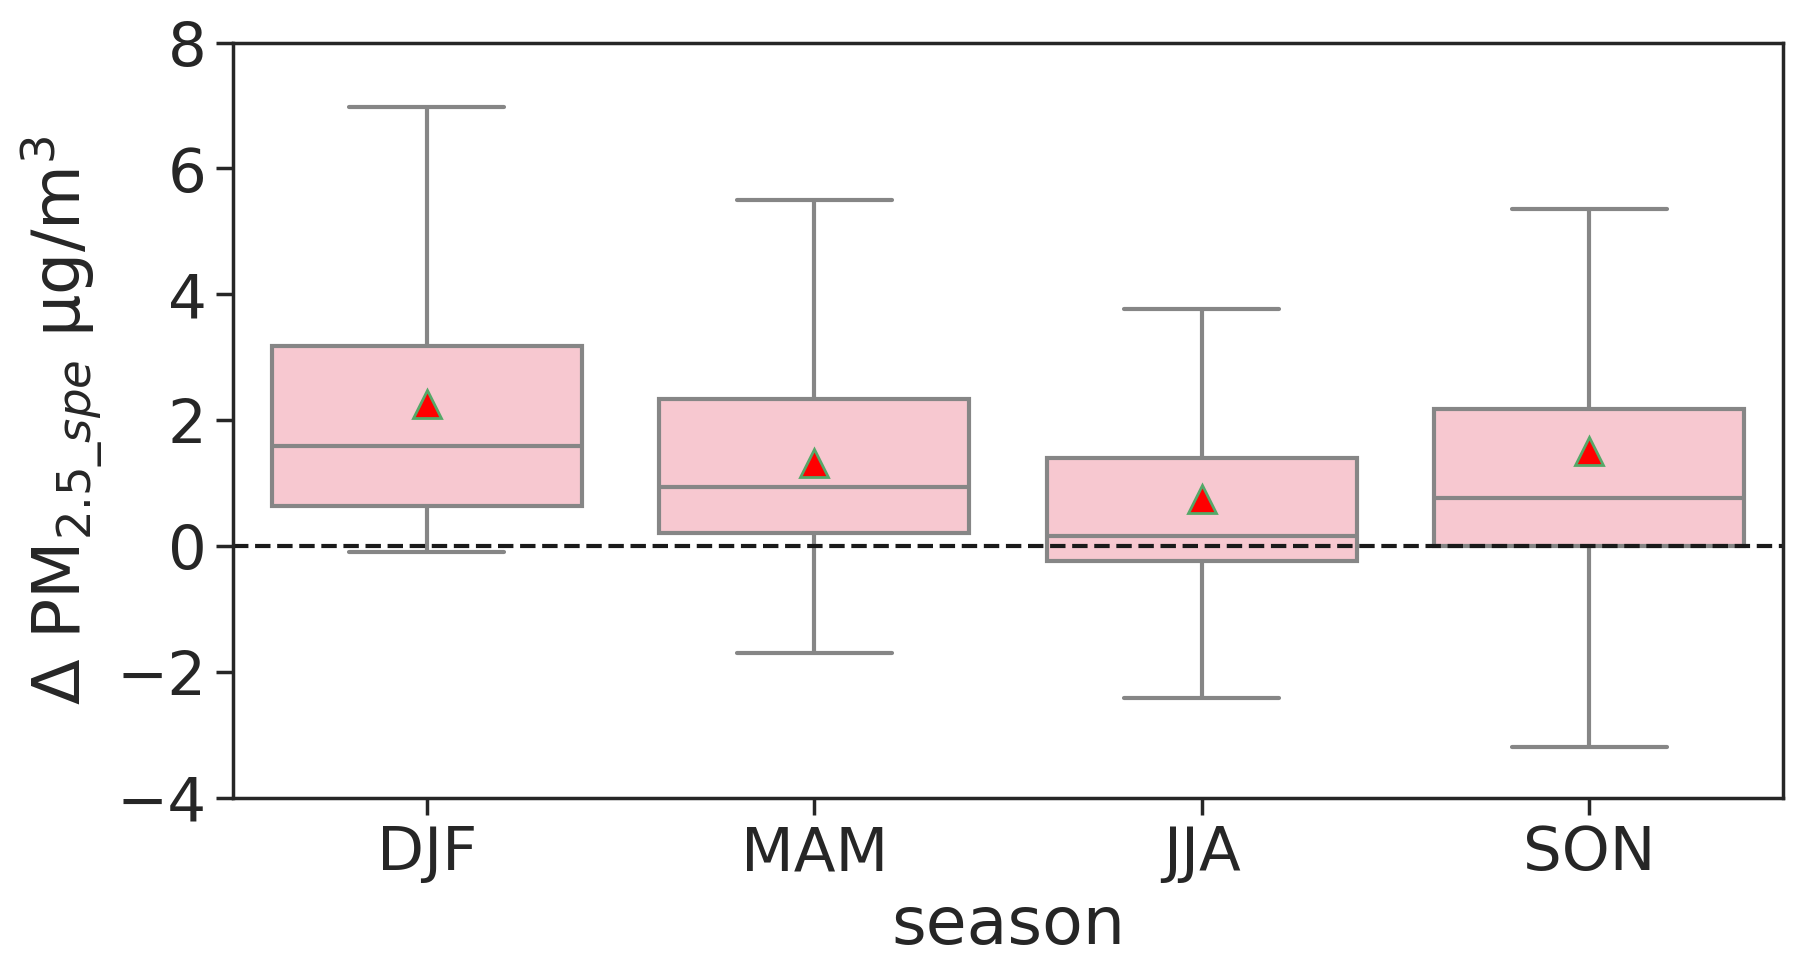

In [62]:
sns.set(color_codes=True, font_scale = 2)
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
meanpointprops = dict( markerfacecolor='red', markersize=10)
fig, ax = plt.subplots(figsize=(10, 5), dpi = 200)
ax = sns.boxplot(x="season", y="MB_PM_speciation", showfliers=False,showmeans = True, data=valid_data,meanprops = meanpointprops, color="pink")
ax.axhline(0, color='k',linestyle = '--',linewidth = 1.5)
# ax.set_title('Errors of PM$_{2.5}$ due to speciation')
ax.set_ylabel('$\Delta$ PM$_{2.5\_spe}$ µg/m$^{3}$')
ax.set_ylim(-4,8)
# plt.legend(bbox_to_anchor=(0.45, 0.98), loc=2, borderaxespad=0.)
labels = ['DJF','MAM','JJA','SON']
ax.set_xticklabels(labels)
# ax.text(0.05, 0.95,'b)', ha='center', va='center', transform=ax.transAxes)


In [63]:
r_spe = []
var_uni = ['MB_PM_speciation']
label_arr = ['$\Delta$ PM$_{2.5\_spe}$ µg/m$^{3}$']

for iseason in range(0,4):
    for il,iv in zip(label_arr, var_uni):
        sub_data = valid_data[(valid_data['season'] ==  iseason) &(valid_data['MB_ori'] > -30) &(valid_data['MB_ori'] < 30) & (valid_data['MB_PM_speciation'] > -30) &(valid_data['MB_PM_speciation'] < 30)] 
        x = sub_data[iv]
    #     x = sm.add_constant(x)
        y = sub_data['MB_ori']
        sns.set(style="white", color_codes=True)
        results = sm.OLS(y,sm.add_constant(x)).fit()
        r_spe.append(results.rsquared**0.5)

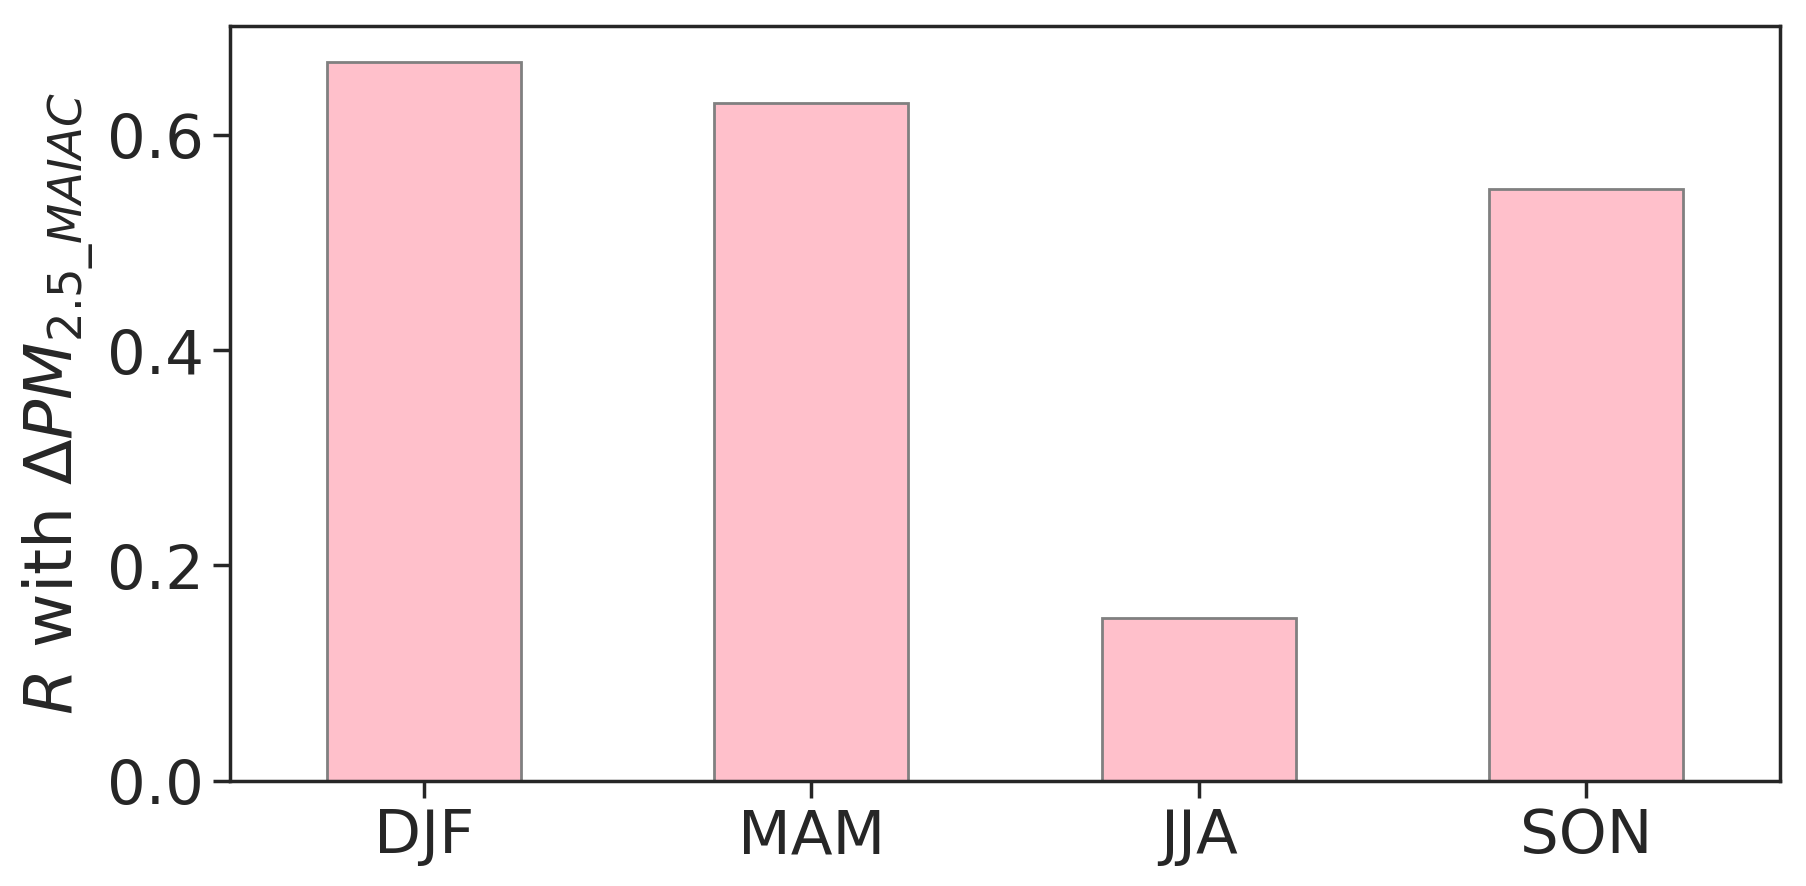

In [64]:
sns.set(color_codes=True, font_scale = 2)
color_arr = sns.color_palette("Set2", 8)
color_arr_sub = color_arr[2:8]

# df_pm_all[var_name].boxplot()
# sns.set(color_codes=True, font_scale = 1.18)
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
fig, ax = plt.subplots(figsize=(10, 5), dpi = 200)
df = pd.DataFrame({'Var':['DJF','MAM','JJA','SON'], 'R':r_spe})
df.plot.bar(ax = ax, x='Var', y='R', rot=0, color = 'pink',edgecolor = ['grey','grey','grey','grey'],linewidth = 1)
ax.set_xlabel('')
ax.set_ylabel('$R$ with $\Delta PM_{2.5\_MAIAC}$')
ax.legend_.remove()

In [65]:
species_list = ["SNA","OC","EC","Fine_Soil"]
CMAQ_ind = ['CMAQ_' + s  for s in species_list]
CMAQ_AOD_C_ind = ['CMAQ_AOD_C' + s  for s in species_list]
AQS_in = ['AQS_' + s  for s in species_list]
CMAQ_AOD_redistribute_in = ['CMAQ_AOD_redistr_' + s  for s in species_list]

valid_data.loc[(valid_data.month == 12) | (valid_data.month == 1) | (valid_data.month == 2),'season'] = 0
valid_data.loc[(valid_data.month == 3) | (valid_data.month == 4) | (valid_data.month == 5),'season'] = 1
valid_data.loc[(valid_data.month == 6) | (valid_data.month == 7) | (valid_data.month == 8),'season'] = 2
valid_data.loc[(valid_data.month == 9) | (valid_data.month == 10) | (valid_data.month == 11),'season'] = 3 

data_composite = valid_data.groupby(['season']).mean()
d = {}
for species in species_list:
    d[species] = data_composite[['CMAQ_' + species, 'AQS_' + species ]]
    old_names = ['CMAQ_' + species, 'AQS_' + species ]
    new_names = ['CMAQ','AQS']
    d[species].rename(columns=dict(zip(old_names, new_names)), inplace=True)

    
def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns = ['c1', 'c2', 'values']
    df['DF'] = name
    return df

d_2 = {}
for ind_a, name in enumerate(d.keys()):
    str_in = str(ind_a)
    d_2[str_in + name] = prep_df(d[name], str_in + name)

df = pd.concat(d_2)

df = df.reset_index(level=0, drop=True)



/home/xjin/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


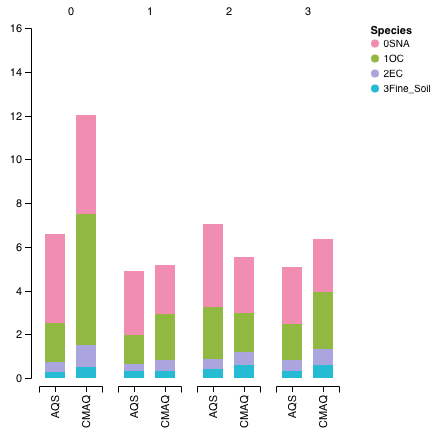

In [66]:
import altair as alt
alt.Chart(df).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('c2:N',
        axis=alt.Axis(
            grid=False,
            title='')),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(values):Q',
        axis=alt.Axis(
            grid=False,
            title='', format = '3.0f'
      ),scale=alt.Scale(domain=[0, 15])),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('c1:N',
                 axis=alt.Axis(
            title='')),
    # tell Altair which field to use for color segmentation 
    color=alt.Color('DF:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#F18DB0','#91B841', '#AAA5DE','#25BBD3','#E69C2E'],
            ),
            legend=alt.Legend( title='Species'),
        ))\
    .configure_facet_cell(
    # remove grid lines around column clusters
        strokeWidth=0.0)

# alt.Chart(df).savechart('Figure5_stacked_bar_chart_species_contribution.html')
# plt.savefig(DIR+'Figure5_stacked_bar_chart_species_contribution.pdf',format = 'pdf')

# Figure 7

In [67]:
data_merge = pd.read_csv('Discover_AQ_data_merge_KAPM.csv')
df_CMAQ = pd.read_csv('Discover_AQ_data_df_cmaq.csv')

In [68]:
df_CMAQ_filter = df_CMAQ.dropna(subset=['CMAQ_EXT_Aircraft_TOT_dist','CMAQ_EXT_Aircraft_TOT_column_mass','CMAQ_EXT_Aircraft_TOT_RH','EXTamb'])

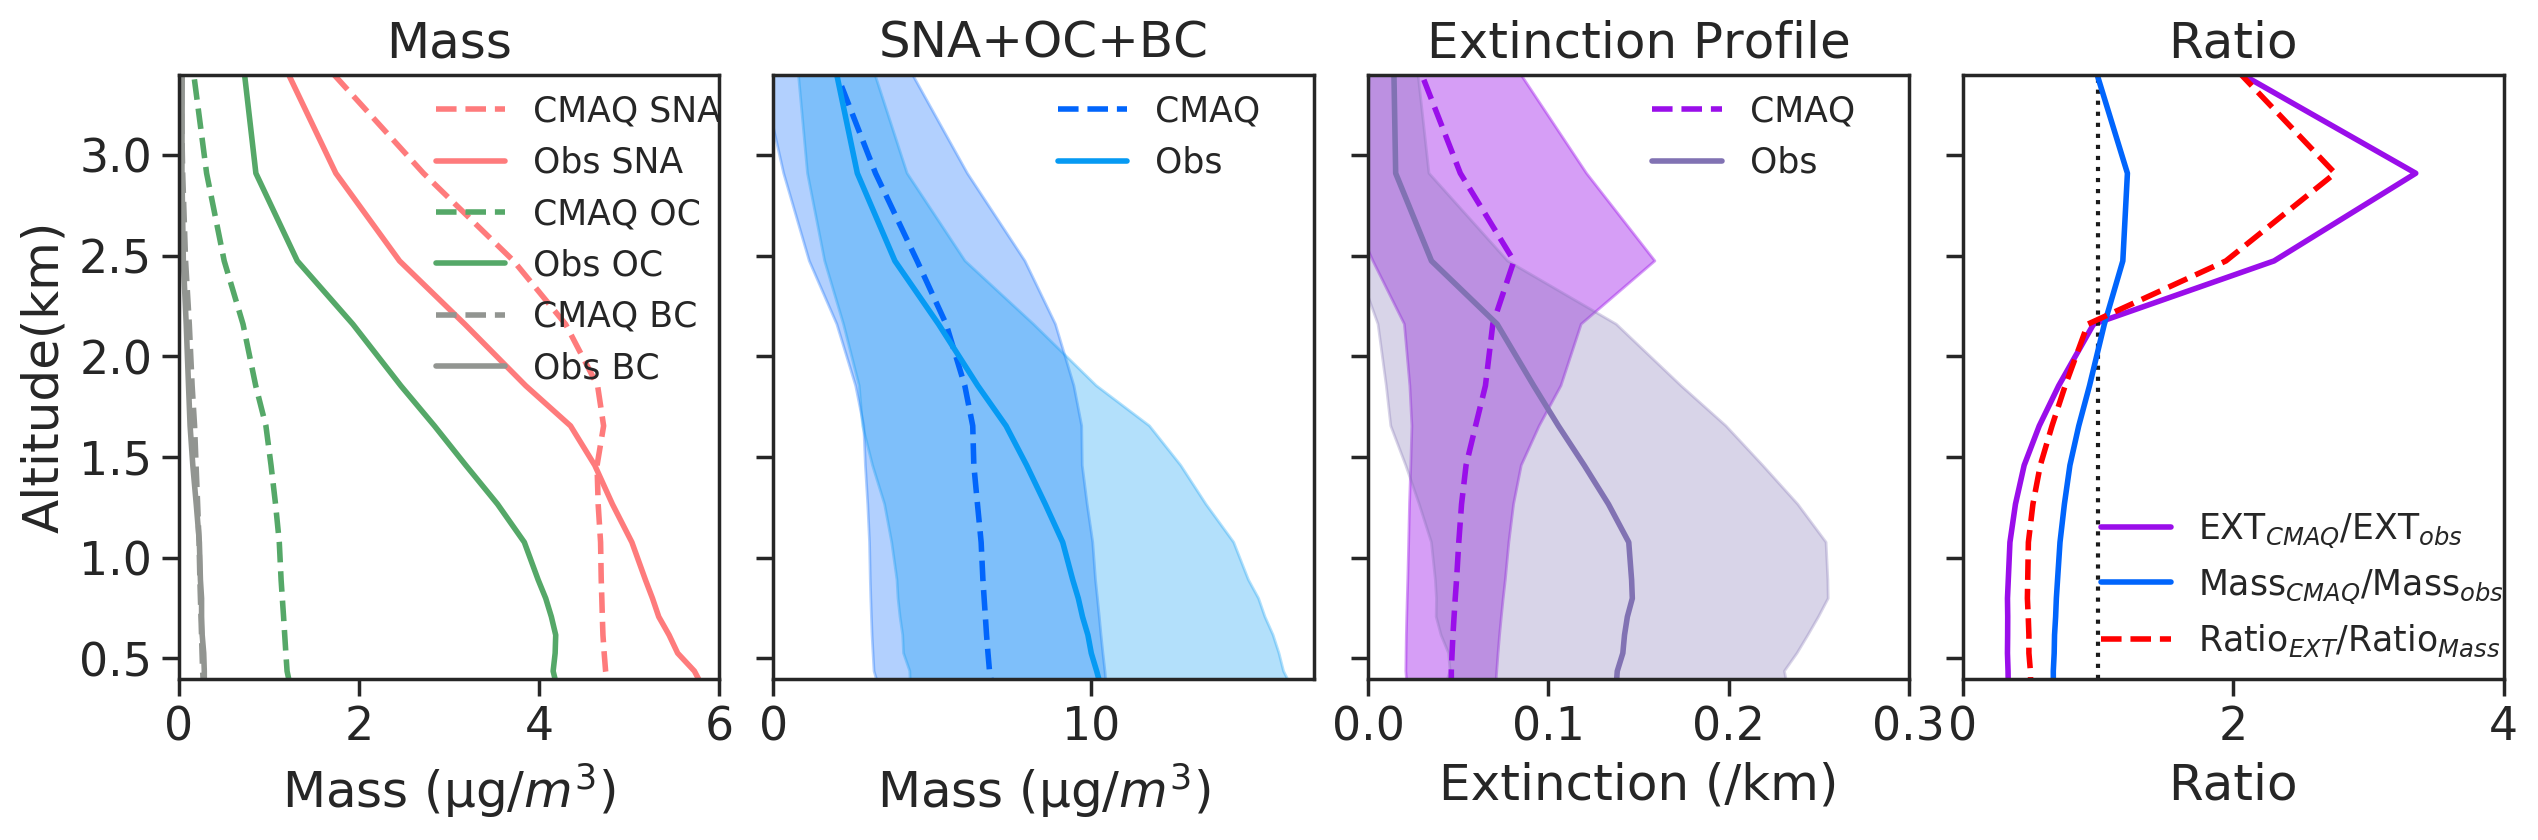

In [69]:
sns.set(color_codes=True, font_scale = 1.5)
sns.set_style("ticks", {"xtick.major.size": 1, "ytick.major.size": 1})

data_composite = data_merge.groupby(['ind_ALT']).mean()  
data_composite = data_composite.reset_index()
df_CMAQ_avg = df_CMAQ_filter.groupby(['ind_ALT']).mean()
df_CMAQ_avg = df_CMAQ_avg.reset_index()
df_CMAQ_std = df_CMAQ_filter.groupby(['ind_ALT']).std()
df_CMAQ_std = df_CMAQ_std.reset_index()
fig, axarr = plt.subplots(1,4, figsize=(15, 4),sharey = True, dpi = 200)
ax = axarr[1]
ax.plot(df_CMAQ_avg['CONC_TOT'], df_CMAQ_avg['Alt'],label = 'CMAQ', linestyle='--',color = sns.xkcd_rgb["bright blue"], linewidth=2)
ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['CONC_TOT']-df_CMAQ_std['CONC_TOT'],df_CMAQ_avg['CONC_TOT']+df_CMAQ_std['CONC_TOT'], color = sns.xkcd_rgb['bright blue'],alpha = 0.3)
# ax.errorbar(df_CMAQ_avg['CONC_TOT'], df_CMAQ_avg['Alt'], xerr=df_CMAQ_std['CONC_TOT'], fmt='o')

# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXT']-df_CMAQ_std['EXT'],df_CMAQ_avg['EXT']+df_CMAQ_std['EXT'], alpha = 0.3)
# for iv,il in zip(var_str_CMAQ,label_arr):
#     ax.plot(df_CMAQ_avg[iv], df_CMAQ_avg['Alt'],label = il, linestyle='--')

ax.plot(df_CMAQ_avg['CMAQ_CONC_Aircraft_TOT_interp'], df_CMAQ_avg['Alt'],label = 'Obs', c = sns.xkcd_rgb["azure"], linewidth=2)
ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['CMAQ_CONC_Aircraft_TOT_interp']-df_CMAQ_std['CMAQ_CONC_Aircraft_TOT_interp'],df_CMAQ_avg['CMAQ_CONC_Aircraft_TOT_interp']+df_CMAQ_std['CMAQ_CONC_Aircraft_TOT_interp'], color = sns.xkcd_rgb["azure"], alpha = 0.3)

# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXTamb']-df_CMAQ_zone_mean_std['EXTamb'],df_CMAQ_avg['EXTamb']+df_CMAQ_zone_mean_std['EXTamb'], alpha = 0.3)
# ax.plot(df_CMAQ_avg['EXTdry'], df_CMAQ_avg['Alt'],label = 'EXTdry', c = 'grey', linewidth=1)
# ax.set_ylabel('Height(km)')
ax.set_xlabel('Mass (µg/${m^3}$)')
ax.legend(bbox_to_anchor=(0.5, 0.99), loc=2, borderaxespad=0.,frameon=False, fontsize = 'x-small')
ax.set_title('SNA+OC+BC')
ax.set_ylim(0.4,3.4)
ax.set_xlim(0,17)

ax = axarr[2]
ax.plot(df_CMAQ_avg['EXT'], df_CMAQ_avg['Alt'],label = 'CMAQ', linestyle='--', color = sns.xkcd_rgb["violet"], linewidth=2)
ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXT']-df_CMAQ_std['EXT'],df_CMAQ_avg['EXT']+df_CMAQ_std['EXT'], color = sns.xkcd_rgb["violet"], alpha = 0.4)
# ax.errorbar(df_CMAQ_avg['CONC_TOT'], df_CMAQ_avg['Alt'], xerr=df_CMAQ_std['CONC_TOT'], fmt='o')

# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXT']-df_CMAQ_std['EXT'],df_CMAQ_avg['EXT']+df_CMAQ_std['EXT'], alpha = 0.3)
# for iv,il in zip(var_str_CMAQ,label_arr):
#     ax.plot(df_CMAQ_avg[iv], df_CMAQ_avg['Alt'],label = il, linestyle='--')

ax.plot(df_CMAQ_avg['EXTamb'], df_CMAQ_avg['Alt'],label = 'Obs', c = 'm', linewidth=2)
ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXTamb']-df_CMAQ_std['EXTamb'],df_CMAQ_avg['EXTamb']+df_CMAQ_std['EXTamb'], color = 'm', alpha = 0.3)

# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXTamb']-df_CMAQ_zone_mean_std['EXTamb'],df_CMAQ_avg['EXTamb']+df_CMAQ_zone_mean_std['EXTamb'], alpha = 0.3)
# ax.plot(df_CMAQ_avg['EXTdry'], df_CMAQ_avg['Alt'],label = 'EXTdry', c = 'grey', linewidth=1)
# ax.set_ylabel('Height(km)')
ax.set_xlabel('Extinction (/km)')
ax.legend(bbox_to_anchor=(0.5, 0.99), loc=2, borderaxespad=0.,frameon=False, fontsize = 'x-small')
ax.set_title('Extinction Profile')
ax.set_ylim(0.4,3.4)
ax.set_xlim(0,0.3)


ax = axarr[0]
ax.plot(df_CMAQ_avg['CONC_SULF'], df_CMAQ_avg['Alt'],label = 'CMAQ SNA', linestyle='--',color = sns.xkcd_rgb["salmon pink"], linewidth=2)
ax.plot(df_CMAQ_avg['CMAQ_CONC_Aircraft_SULF_interp'], df_CMAQ_avg['Alt'],label = 'Obs SNA', c = sns.xkcd_rgb["salmon pink"], linewidth=2)

ax.plot(df_CMAQ_avg['CONC_OC'], df_CMAQ_avg['Alt'],label = 'CMAQ OC', linestyle='--',color = 'g', linewidth=2)
# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['CONC_SULF']-df_CMAQ_std['CONC_SULF'],df_CMAQ_avg['CONC_SULF']+df_CMAQ_std['CONC_SULF'], color = 'm',alpha = 0.3)
# ax.errorbar(df_CMAQ_avg['CONC_TOT'], df_CMAQ_avg['Alt'], xerr=df_CMAQ_std['CONC_TOT'], fmt='o')

# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXT']-df_CMAQ_std['EXT'],df_CMAQ_avg['EXT']+df_CMAQ_std['EXT'], alpha = 0.3)
# for iv,il in zip(var_str_CMAQ,label_arr):
#     ax.plot(df_CMAQ_avg[iv], df_CMAQ_avg['Alt'],label = il, linestyle='--')


ax.plot(df_CMAQ_avg['CMAQ_CONC_Aircraft_OC_interp'], df_CMAQ_avg['Alt'],label = 'Obs OC', c = 'g', linewidth=2)


ax.plot(df_CMAQ_avg['CONC_BC'], df_CMAQ_avg['Alt'],label = 'CMAQ BC', linestyle='--',color = sns.xkcd_rgb["grey"], linewidth=2)
ax.plot(df_CMAQ_avg['CMAQ_CONC_Aircraft_BC_interp'], df_CMAQ_avg['Alt'],label = 'Obs BC', c = sns.xkcd_rgb["grey"], linewidth=2)

# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['CMAQ_CONC_Aircraft_SULF_interp']-df_CMAQ_std['CMAQ_CONC_Aircraft_SULF_interp'],df_CMAQ_avg['CMAQ_CONC_Aircraft_SULF_interp']+df_CMAQ_std['CMAQ_CONC_Aircraft_TOT_interp'], color = 'green', alpha = 0.3)

# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXTamb']-df_CMAQ_zone_mean_std['EXTamb'],df_CMAQ_avg['EXTamb']+df_CMAQ_zone_mean_std['EXTamb'], alpha = 0.3)
# ax.plot(df_CMAQ_avg['EXTdry'], df_CMAQ_avg['Alt'],label = 'EXTdry', c = 'grey', linewidth=1)
ax.set_ylabel('Altitude(km)')
ax.set_xlabel('Mass (µg/${m^3}$)')
ax.legend(bbox_to_anchor=(0.45, 0.99), loc=2, borderaxespad=0.,frameon=False, fontsize = 'x-small')
ax.set_title('Mass')
ax.set_ylim(0.4,3.4)
ax.set_xlim(0,6)



#Figure 4
ax =axarr[3]
ax.plot(df_CMAQ_avg['EXT']/df_CMAQ_avg['EXTamb'], df_CMAQ_avg['Alt'],label = 'EXT$_{CMAQ}$/EXT$_{obs}$', color = sns.xkcd_rgb["violet"],linestyle='-', linewidth=2)
# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXT']-df_CMAQ_zone_mean_std['EXT'],df_CMAQ_avg['EXT']+df_CMAQ_zone_mean_std['EXT'], alpha = 0.3)
# ax.errorbar(df_CMAQ_avg['EXT'], df_CMAQ_avg['Alt'], xerr=df_CMAQ_std['EXT'], fmt='o')

# for iv,il in zip(var_str_CMAQ,label_arr):
#     ax.plot(df_CMAQ_avg['EXTamb']/df_CMAQ_avg[iv], df_CMAQ_avg['Alt'],label = il, linestyle='--')
plt.axvline(1, color='k', linestyle = ':')

# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXT']-df_CMAQ_std['EXT'],df_CMAQ_avg['EXT']+df_CMAQ_std['EXT'], alpha = 0.3)
ax.plot(df_CMAQ_avg['CONC_TOT']/df_CMAQ_avg['CMAQ_CONC_Aircraft_TOT_interp'], df_CMAQ_avg['Alt'],label = 'Mass$_{CMAQ}$/Mass$_{obs}$', c =  sns.xkcd_rgb["bright blue"], linestyle='-', linewidth=2)
# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXTamb']-df_CMAQ_zone_mean_std['EXTamb'],df_CMAQ_avg['EXTamb']+df_CMAQ_zone_mean_std['EXTamb'], alpha = 0.3)
# ax.plot(df_CMAQ_avg['EXTdry'], df_CMAQ_avg['Alt'],label = 'EXTdry', c = 'grey', linewidth=1)
ax.plot((df_CMAQ_avg['EXT']/df_CMAQ_avg['EXTamb']/(df_CMAQ_avg['CONC_TOT']/df_CMAQ_avg['CMAQ_CONC_Aircraft_TOT_interp'])), df_CMAQ_avg['Alt'],label ='Ratio$_{EXT}$/Ratio$_{Mass}$', c = 'red', linestyle='--', linewidth=2)

# ax.set_ylabel('Height(km)')
ax.set_xlabel('Ratio')
ax.legend(bbox_to_anchor=(0.23, 0.3), loc=2, borderaxespad=0.,frameon=False, fontsize = 'x-small')
ax.set_title('Ratio')
ax.set_ylim(0.4,3.4)
ax.set_xlim(0,4)

fig.subplots_adjust(hspace=0.3, wspace = 0.1)


# Figure 8

In [70]:
data_merge = pd.read_csv('Discover_AQ_data_merge_KAPM.csv')
# df_CMAQ = pd.read_csv('Discover_AQ_data_df_cmaq_rayleigh.csv')
df_CMAQ = pd.read_csv('Discover_AQ_data_df_cmaq.csv')
df_pm_all = pd.read_csv('Discover_AQ_data_df_pm_all.csv')
df_pm_aod_all = pd.read_csv('Discover_AQ_data_df_pm_aod_all.csv')
df_aod_all = pd.read_csv('Discover_AQ_data_df_aod_all.csv')
df_CMAQ_filter = df_CMAQ.dropna(subset=['CMAQ_EXT_Aircraft_TOT_dist','CMAQ_EXT_Aircraft_TOT_column_mass','CMAQ_EXT_Aircraft_TOT_RH','EXTamb'])

In [72]:
df_pm_all = df_pm_all.dropna(subset=['MAIAC'])

In [73]:
var_arr =['Rel','Mass','Column','Profile','MEE','RH','RH+Mass','AQS']
for iv in var_arr:
     df_pm_all[iv+'dif'] = df_pm_all['MAIAC'] - df_pm_all[iv]

In [74]:
df_aod_all= df_aod_all.dropna(subset=['AERONET'])

In [75]:
var_arr =['Mass','Column','Profile','MEE','RH','RH+Mass','CMAQ','AERONET']
for iv in var_arr:
     df_aod_all[iv+'dif'] = df_aod_all[iv] - df_aod_all['CMAQ']

In [76]:
r = []
dif_arr = [s + 'dif'  for s in var_arr]
for iv in dif_arr:
    X = df_aod_all[iv]
    X = sm.add_constant(X)
    y = df_aod_all['AERONETdif']
    results = sm.OLS(y, X).fit()
    r.append(results.rsquared**0.5)

In [152]:
var_arr =['Mass','Column','Profile','MEE','RH','RH+Mass','CMAQ','Obs']
for iv in var_arr:
     df_pm_aod_all[iv+'dif'] = df_pm_aod_all[iv] - df_pm_aod_all['CMAQ']

In [161]:
var_arr =['Rel','Mass','Column','Profile','MEE','RH','RH+Mass','AQS']


In [77]:
df_CMAQ_filter = df_CMAQ_filter[df_CMAQ_filter.CMAQ_ext_Aircraft_MEE_amb > 0]

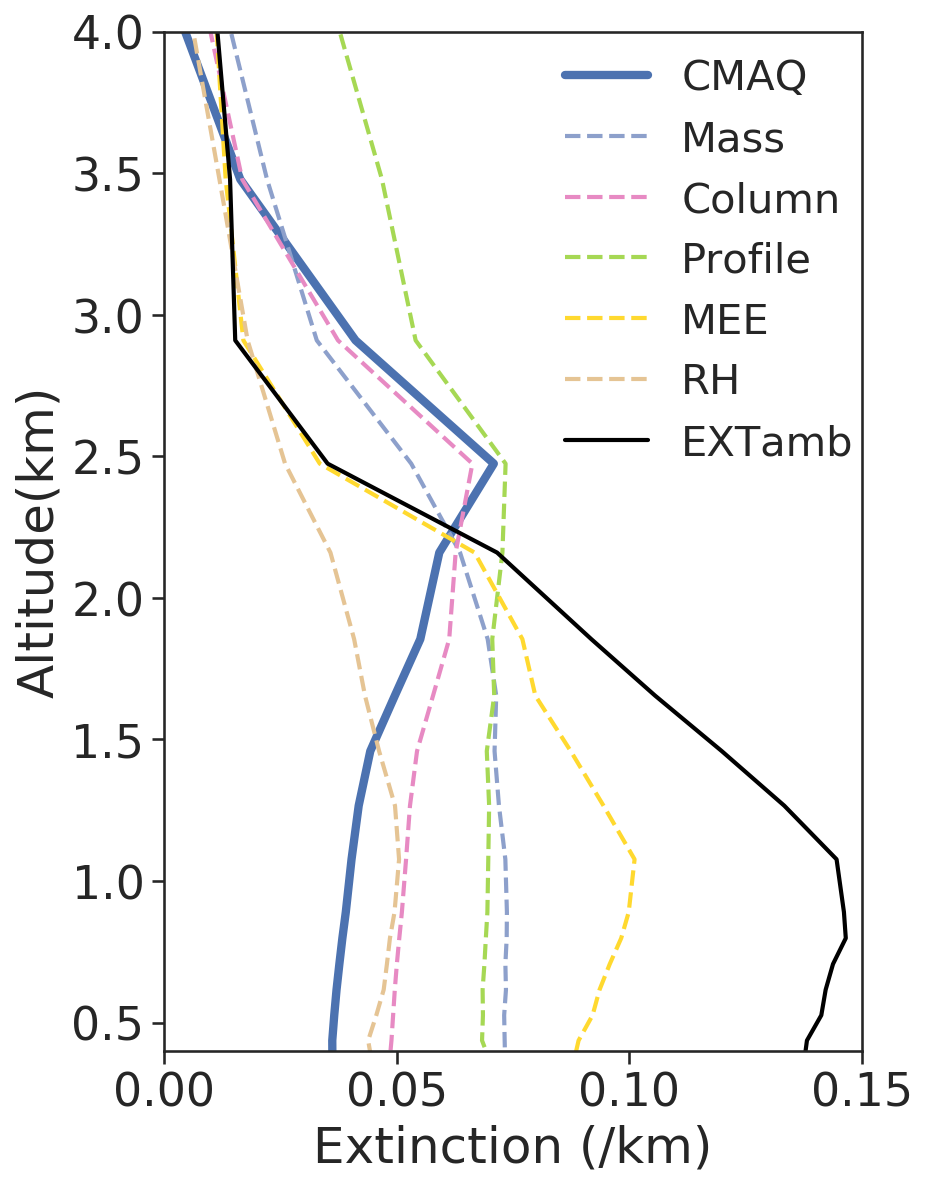

In [78]:
color_arr = sns.color_palette("Set2", 8)
color_arr_sub = color_arr[2:7]
sns.set(color_codes=True, font_scale = 2)
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

var_str_CMAQ = ['CMAQ_EXT_Aircraft_TOT_interp',\
                'CMAQ_EXT_Aircraft_TOT_column_mass_TOT','CMAQ_EXT_Aircraft_TOT_dist','CMAQ_ext_Aircraft_MEE_amb','CMAQ_EXT_Aircraft_TOT_RH_noint']
label_arr = ['Mass','Column','Profile','MEE','RH']
data_composite = data_merge.groupby(['ind_ALT']).mean()  
data_composite = data_composite.reset_index()
df_CMAQ_avg = df_CMAQ_filter.groupby(['ind_ALT']).mean()
df_CMAQ_avg = df_CMAQ_avg.reset_index()
df_CMAQ_std = df_CMAQ_filter.groupby(['ind_ALT']).std()
df_CMAQ_std = df_CMAQ_std.reset_index()
fig, ax = plt.subplots( figsize=(6, 9), dpi = 150)
df_CMAQ_avg['EXT'] = df_CMAQ_avg['EXT'] - 0.01
ax.plot(df_CMAQ_avg['EXT'], df_CMAQ_avg['Alt'],label = 'CMAQ', linestyle='-', linewidth=4)
# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXT']-df_CMAQ_zone_mean_std['EXT'],df_CMAQ_avg['EXT']+df_CMAQ_zone_mean_std['EXT'], alpha = 0.3)
# ax.errorbar(df_CMAQ_avg['EXT'], df_CMAQ_avg['Alt'], xerr=df_CMAQ_std['EXT'], fmt='o')

# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXT']-df_CMAQ_std['EXT'],df_CMAQ_avg['EXT']+df_CMAQ_std['EXT'], alpha = 0.3)
for iv,il,color in zip(var_str_CMAQ,label_arr,color_arr_sub):
    ax.plot(df_CMAQ_avg[iv], df_CMAQ_avg['Alt'],label = il, linestyle='--',color = color, linewidth=2)

ax.plot(df_CMAQ_avg['EXTamb'], df_CMAQ_avg['Alt'],label = 'EXTamb', c = 'black', linewidth=2)
# ax.fill_betweenx(df_CMAQ_avg['Alt'],df_CMAQ_avg['EXTamb']-df_CMAQ_zone_mean_std['EXTamb'],df_CMAQ_avg['EXTamb']+df_CMAQ_zone_mean_std['EXTamb'], alpha = 0.3)
# ax.plot(df_CMAQ_avg['EXTdry'], df_CMAQ_avg['Alt'],label = 'EXTdry', c = 'grey', linewidth=1)
ax.set_ylabel('Altitude(km)')
ax.set_xlabel('Extinction (/km)')
ax.legend(bbox_to_anchor=(0.55, 0.99), loc=2, borderaxespad=0.,frameon=False, fontsize = 'small')
# ax.set_title('a) Extinction Profile')
ax.set_ylim(0.4,4)
ax.set_xlim(0,0.15)

fig.subplots_adjust(hspace=0.2, wspace = 0.25)


# Figure 9

In [230]:
df_CMAQ = pd.read_csv('Radiosonde_RH_all_interpolate_to_CMAQ_pressure_level_with_EXT.csv', parse_dates=['Date'])

In [231]:
AOD_df = pd.read_csv('Radiosonde_RH_all_interpolate_to_CMAQ_pressure_level_with_EXT_AOD_df.csv', parse_dates=['Date'])

In [249]:
AOD_sub = AOD_df[(AOD_df['Station ID'] != 'CAM00071722') ]
AOD_sub_day = AOD_sub.groupby(['Station ID','Date']).mean()

In [250]:
df_CMAQ_surface = df_CMAQ[df_CMAQ.ind_ALT  == 0]
df_CMAQ_day  = df_CMAQ_surface.groupby(['Station ID','Date']).mean()

In [251]:
AOD_sub_day['RH_surface'] = df_CMAQ_day['RH']

In [252]:
AOD_sub_day['RH_surface_bin'] = (AOD_sub_day['RH_surface']/10).values.astype('int')*10
AOD_sub_day.loc[AOD_sub_day.RH_surface>80, 'RH_surface_bin'] = ((AOD_sub_day.loc[AOD_sub_day.RH_surface>80]['RH_surface']).values/5).astype('int')*5
AOD_sub_day.loc[AOD_sub_day.RH_surface_bin == 100, 'RH_surface_bin'] = 95


In [253]:
RH_bin = AOD_sub_day['RH_surface_bin'].unique()

RH_bin.sort()
RH_bin

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 85, 90, 95])

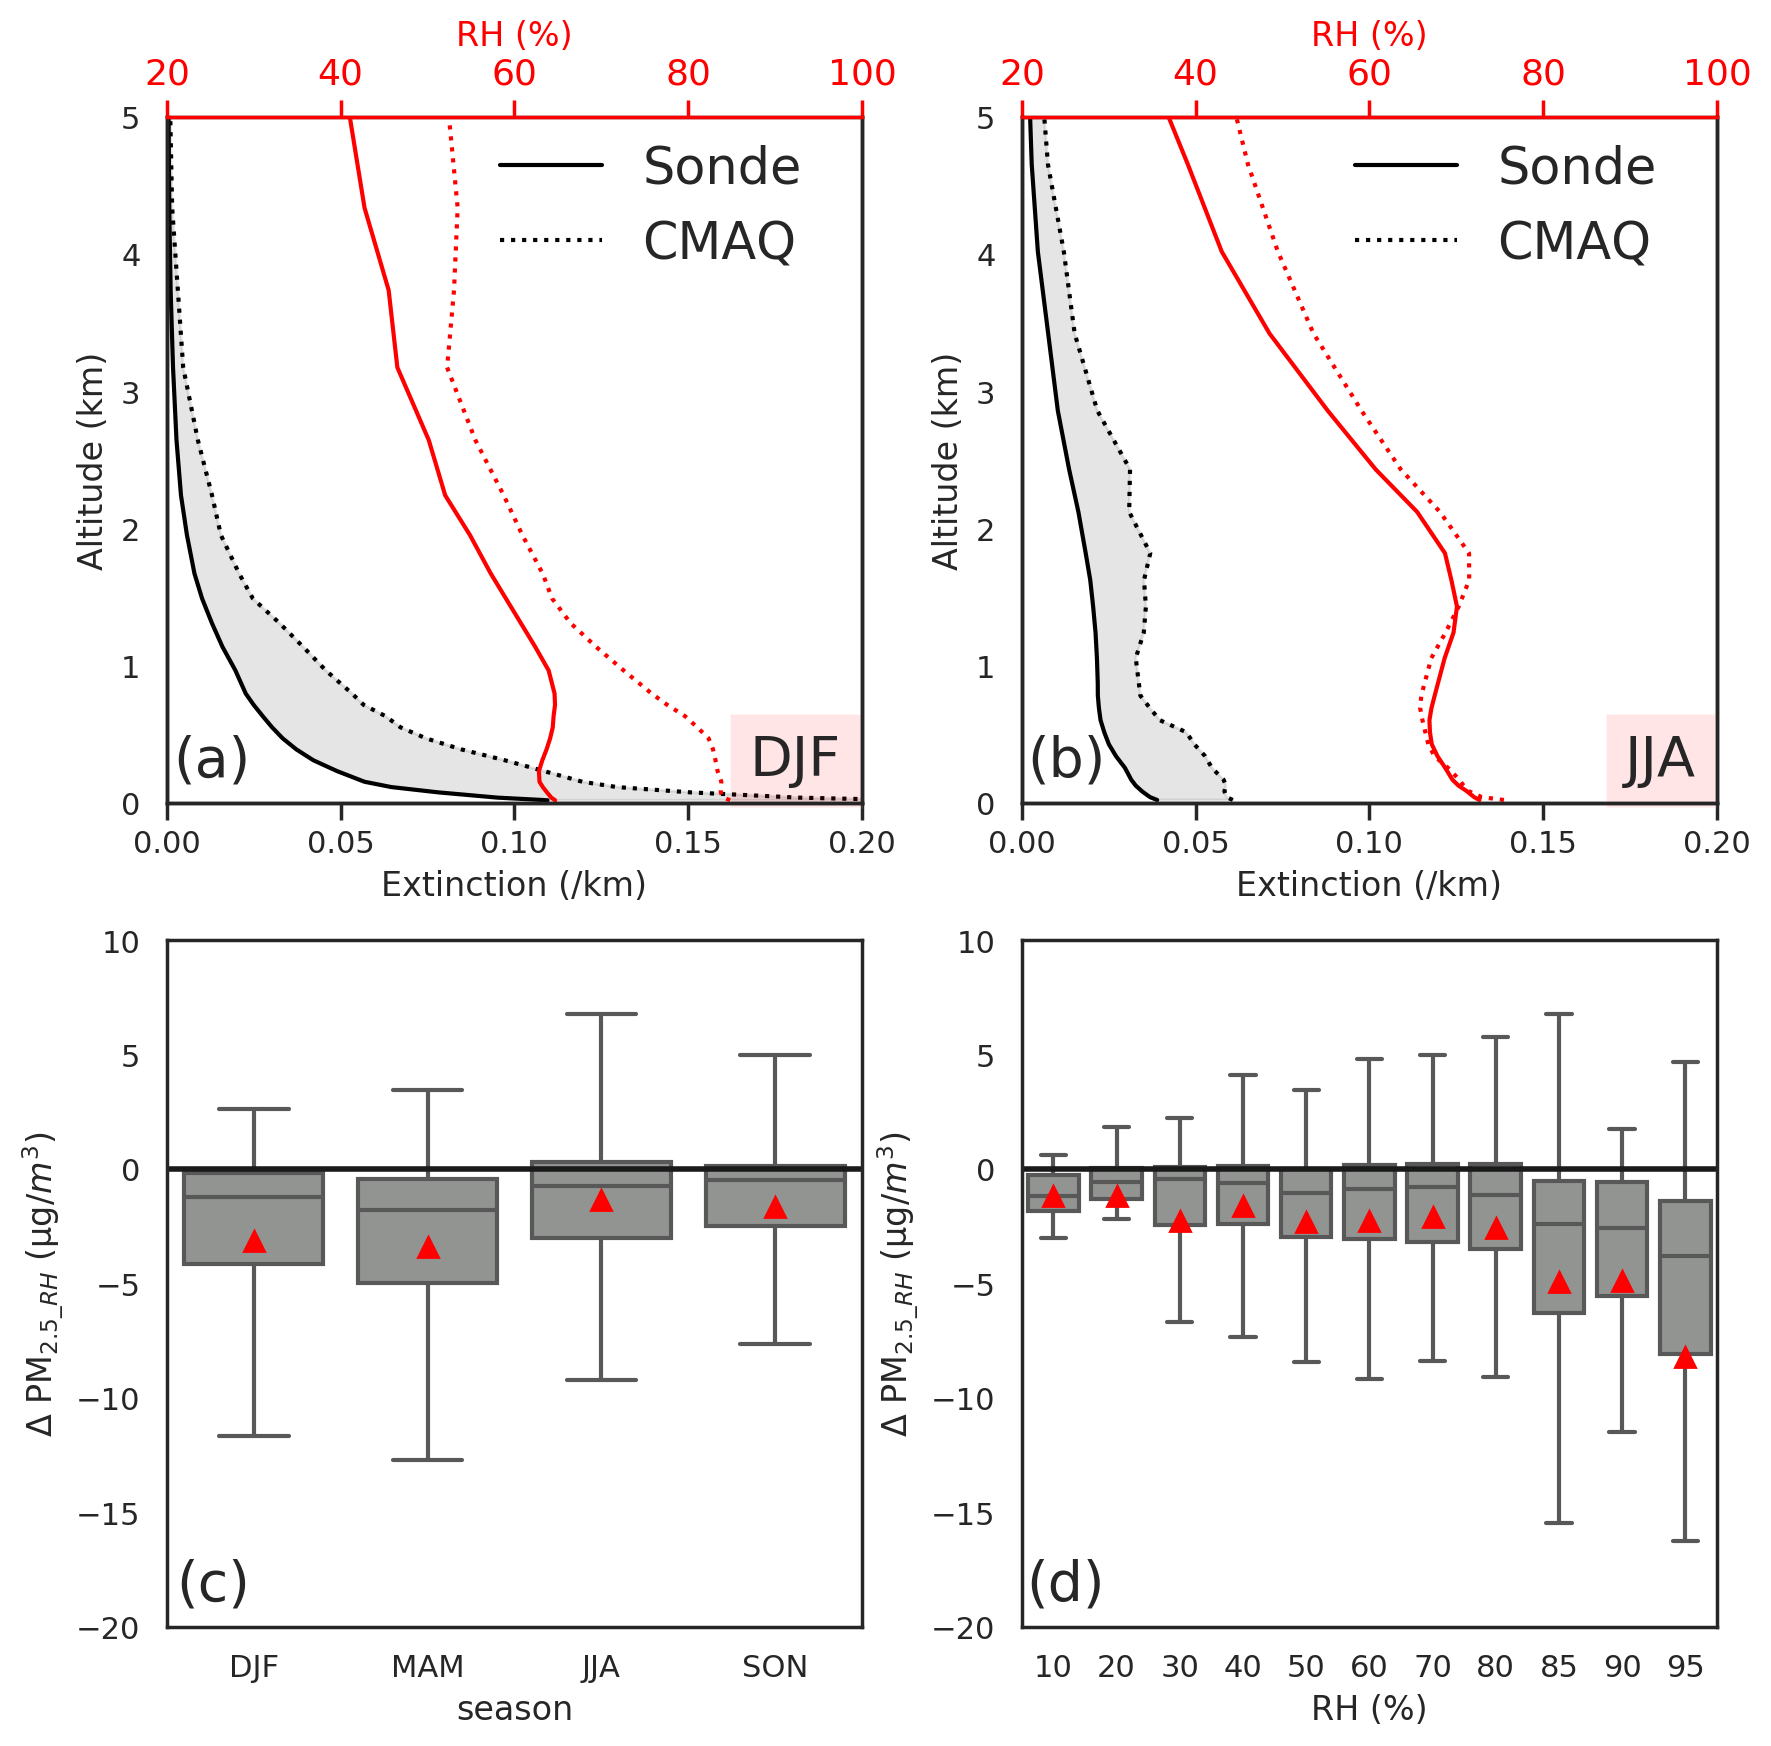

In [254]:
AOD_sub = AOD_df[(AOD_df.NMB < 300) & (AOD_df.MB_PM < 20) & (AOD_df.MB_PM > -30) & (AOD_df['Station ID'] != 'CAM00071722') ]

df_CMAQ_US = df_CMAQ[df_CMAQ['Station ID'] != 'CAM00071722']
sns.set(style="white", color_codes=True, font_scale = 1)

fig, axarr = plt.subplots(2,2, figsize=(10, 10), dpi = 200)
df_sub_winter = df_CMAQ_US[(df_CMAQ_US['Month'] == 12) | (df_CMAQ_US['Month'] == 1) | (df_CMAQ_US['Month'] == 2)]
df_sub_summer = df_CMAQ_US[(df_CMAQ_US['Month'] == 6) | (df_CMAQ_US['Month'] ==7) | (df_CMAQ_US['Month'] == 8)]
df_sub_spring = df_CMAQ_US[(df_CMAQ_US['Month'] == 3) | (df_CMAQ_US['Month'] ==4) | (df_CMAQ_US['Month'] == 5)]
df_sub_fall = df_CMAQ_US[(df_CMAQ_US['Month'] == 9) | (df_CMAQ_US['Month'] ==10) | (df_CMAQ_US['Month'] == 11)]
df_season = [df_sub_winter,  df_sub_summer]
season_str = ['DJF','JJA']
font = {'size'   : 22}


plt.rc('font', **font)

for df_sub,ax,season in zip(df_season, axarr[0,:], season_str):
    data_composite = df_sub.groupby(['ind_ALT']).mean()  
    data_composite = data_composite.reset_index()
    data_composite_min = df_sub.groupby(['ind_ALT']).min()  
    data_composite_min = data_composite_min.reset_index()
    data_composite_max = df_sub.groupby(['ind_ALT']).max()  
    data_composite_max = data_composite_max.reset_index()
    alt = data_composite.BOXH.cumsum()/1000.
    ax.plot(data_composite['EXTRHobs'], alt, color = 'black', linestyle='-', label = 'Sonde')
    ax.fill_betweenx(alt,data_composite['EXTRHobs'],data_composite['EXT'],  color = 'grey',alpha = 0.2  )
#     ax.fill_betweenx(alt,data_composite_min['EXTRHobs'],data_composite['EXTRHobs']+data_composite_std['EXTRHobs'],  color = 'grey',alpha = 0.3)
    ax.plot(data_composite['EXT'], alt, color = 'black',label = 'CMAQ', linestyle=':')
#     ax.fill_betweenx(alt,data_composite_min['EXT'],data_composite['EXT']+data_composite_std['EXT'],  color = 'pink',alpha = 0.5)
    ax2 = ax.twiny()
    ax2.plot(data_composite['RH'], alt, color = 'red', linestyle='-', label = 'Sonde')
    ax2.plot(data_composite['RH_CMAQ'], alt, color = 'red', linestyle=':', label = 'CMAQ')
    ax2.set_xlim(20,100)
    ax2.set_ylim(0,5)
    ax2.set_xlabel('RH (%)')
#     ax.spines['bottom'].set_color('red')
    ax2.spines['top'].set_color('red')
    ax2.xaxis.label.set_color('red')
    ax2.tick_params(axis='x', colors='red', labelsize = 13)

    ax.set_xlabel('Extinction (/km)')
    ax.set_ylabel('Altitude (km)')
#     ax.set_title(season)
    ax.text(0.97, 0.04, season,
             horizontalalignment='right',
             fontsize=20,
             transform = ax.transAxes, bbox={'facecolor':'red', 'alpha':0.1, 'pad':7})
    ax.set_ylim(0,5)
    ax.set_xlim(0,0.2)
    #     ax.invert_yaxis()
    ax.legend(bbox_to_anchor=(0.45, 0.99), loc=2, borderaxespad=0.,frameon=False, fontsize = 'small')
    
    
ax= axarr[1,0]
meanpointprops = dict( markerfacecolor='red', markeredgecolor='red', markersize=7)

sns.boxplot(x = "season", y = 'MB_PM', data =AOD_sub, color=sns.xkcd_rgb["grey"], ax = ax, showfliers=False, showmeans = True,meanprops = meanpointprops, whis = 2)
ax.set_ylim(-20,10)

ax.set_ylabel('$\Delta$ PM$_{2.5\_RH}$ (µg/${m^3}$)')
ax.axhline(0, color='k',linestyle = '-',linewidth = 2)
labels = ['DJF','MAM','JJA','SON']
ax.set_xticklabels(labels)
# month_data = range(1,len(CMAQ)+1)


# month_data = range(1,len(CMAQ)+1)
meanpointprops = dict( markerfacecolor='red', markeredgecolor='red', markersize=7)

ax= axarr[1,1]

AOD_sub_day_sub = AOD_sub_day

# sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
# sns.set(style="white", color_codes=True, font_scale = 2)
# sns.set_style("ticks")
# fig, ax = plt.subplots( figsize=(8, 4), dpi = 150)
sns.boxplot(x = "RH_surface_bin", y = 'MB_PM', data =AOD_sub_day_sub, color=sns.xkcd_rgb["grey"], ax = ax, showfliers=False, showmeans = True,meanprops = meanpointprops, whis = 2)
ax.set_ylim(-20,10)
ax.set_xlim(0.5,11.5)

ax.set_ylabel('$\Delta$ PM$_{2.5\_RH}$ (µg/${m^3}$)')
ax.axhline(0, color='k',linestyle = '-',linewidth = 2)

xticks = ax.get_xticks()
ax.set_xticks(xticks[1:])
ax.set_xlabel('RH (%)')
ax.set_xticklabels(RH_bin[1:])

ax_l = ['(a)','(b)','(c)','(d)']
for ax,l in zip(axarr.ravel(), ax_l):
    ax.text(0.12, 0.04, l,
             horizontalalignment='right',
             fontsize=20,
             transform = ax.transAxes)

# ax.set_xticklabels(labels)
# labels = ['DJF','MAM','JJA','SON']
# ax.set_xticks(np.arange(1,10,1))
# ax.set_xticklabels(labels)
# month_data = range(1,len(CMAQ)+1)
# fig.subplots_adjust(hspace=0.1, wspace = 0.1)
fig.subplots_adjust(hspace=0.2, wspace = 0.23)



# Figure 10

In [153]:
DIR = '/d3jsb/xjin/Plots/AQI_Evaluation/'
data_size = pd.read_csv('CMAQ_SIP_PM25_001_AQI_comparison_NEUS_88101flex_KAPM_clear_land_adj_SIZsity_sen_winter_filter.csv', index_col=False)
data_hygro = pd.read_csv('CMAQ_SIP_PM25_001_AQI_comparison_NEUS_88101flex_KAPM_clear_land_adj_hygro_sen_winter_filter.csv', index_col=False)
data_ref = pd.read_csv('CMAQ_SIP_PM25_001_AQI_comparison_NEUS_88101flex_KAPM_clear_land_adj_REFsity_sen_winter_filter.csv', index_col=False)
data_den = pd.read_csv('CMAQ_SIP_PM25_001_AQI_comparison_NEUS_88101flex_KAPM_clear_land_adj_Density_sen_winter_filter.csv', index_col=False)

In [154]:
data_list = [data_size,data_hygro,data_ref,data_den]

In [155]:
for data in data_list:
    df = pd.DataFrame({'year': data.year,
                       'month': data.month,
                       'day': data.day})
    data['date'] = pd.to_datetime(df)
    data['doy'] = data.date.dt.dayofyear
    # data['MAIAC_AOD'] = data.MAIAC_PM[(data.MAIAC_PM != -9999)] /data.CMAQ_Relation[(data.MAIAC_PM != -9999)]

In [156]:
for data in data_list:
    data['woy'] = (data.doy/7).astype(int)
    data['toy'] = (data.doy/10).astype(int)
    data['foy'] = (data.doy/15).astype(int)
    data.loc[(data.month == 12) | (data.month == 1) | (data.month == 2),'season'] = 0
    data.loc[(data.month == 3) | (data.month == 4) | (data.month == 5),'season'] = 1
    data.loc[(data.month == 6) | (data.month == 7) | (data.month == 8),'season'] = 2
    data.loc[(data.month == 9) | (data.month == 10) | (data.month == 11),'season'] = 3     

In [157]:
mean_arr_sulf = []
min_arr_sulf = []
max_arr_sulf = []

In [158]:
mean_arr_oc = []
min_arr_oc = []
max_arr_oc = []

In [159]:
var_name = ['MAIAC_PM_KAPM','MAIAC_PM_SIZS13', 'MAIAC_PM_SIZS09','MAIAC_PM_SIZS05', 'MAIAC_PM_SIZOM', 'MAIAC_PM_SIZSH', 'MAIAC_PM_SIZSL', 'MAIAC_PM_SIZOH','MAIAC_PM_SIZOL']
var_name_SULF =  ['MAIAC_PM_KAPM','MAIAC_PM_SIZS13', 'MAIAC_PM_SIZS09','MAIAC_PM_SIZS05', 'MAIAC_PM_SIZSH', 'MAIAC_PM_SIZSL']
var_name_OC =  ['MAIAC_PM_KAPM', 'MAIAC_PM_SIZOH','MAIAC_PM_SIZOL', 'MAIAC_PM_SIZOM']
for iv in var_name:
    data_size.loc[data_size[iv] < 0,iv] = np.nan       
data_mean = data_size[var_name_SULF].mean()
min_arr_sulf.append(data_mean.min())
max_arr_sulf.append(data_mean.max())
mean_arr_sulf.append(data_size['MAIAC_PM_KAPM'].mean())

data_mean = data_size[var_name_OC].mean()
min_arr_oc.append(data_mean.min())
max_arr_oc.append(data_mean.max())
mean_arr_oc.append(data_size['MAIAC_PM_KAPM'].mean())

In [160]:
var_name = ['MAIAC_PM_IMPROVE', 'MAIAC_PM_KAPSH', 'MAIAC_PM_KAPSL','MAIAC_PM_KAPOH', 'MAIAC_PM_KAPOL', 'MAIAC_PM_HGF', 'MAIAC_PM_KAPM',]
var_name_SULF =  ['MAIAC_PM_KAPM', 'MAIAC_PM_KAPSH', 'MAIAC_PM_KAPSL']
var_name_OC =  ['MAIAC_PM_KAPM', 'MAIAC_PM_KAPOH','MAIAC_PM_KAPOL']
for iv in var_name:
    data_hygro.loc[data_hygro[iv] < 0,iv] = np.nan
data_mean = data_hygro[var_name_SULF].mean()
min_arr_sulf.append(data_mean.min())
max_arr_sulf.append(data_mean.max())
mean_arr_sulf.append(data_hygro['MAIAC_PM_KAPM'].mean())

data_mean = data_hygro[var_name_OC].mean()
min_arr_oc.append(data_mean.min())
max_arr_oc.append(data_mean.max())
mean_arr_oc.append(data_hygro['MAIAC_PM_KAPM'].mean())

In [161]:
var_name = ['MAIAC_PM_KAPM', 'MAIAC_PM_REFSH', 'MAIAC_PM_REFSL', 'MAIAC_PM_REFOH','MAIAC_PM_REFOL']
var_name_SULF =  ['MAIAC_PM_KAPM', 'MAIAC_PM_REFSH', 'MAIAC_PM_REFSL']
var_name_OC =  ['MAIAC_PM_KAPM', 'MAIAC_PM_REFOH','MAIAC_PM_REFOL']
for iv in var_name:
    data_ref.loc[data_ref[iv] < 0,iv] = np.nan
data_mean = data_ref[var_name_SULF].mean()
min_arr_sulf.append(data_mean.min())
max_arr_sulf.append(data_mean.max())
mean_arr_sulf.append(data_ref['MAIAC_PM_KAPM'].mean())

data_mean = data_ref[var_name_OC].mean()
min_arr_oc.append(data_mean.min())
max_arr_oc.append(data_mean.max())
mean_arr_oc.append(data_ref['MAIAC_PM_KAPM'].mean())

In [162]:
var_name = ['MAIAC_PM_KAPM', 'MAIAC_PM_DENSH', 'MAIAC_PM_DENSL', 'MAIAC_PM_DENOH','MAIAC_PM_DENOL']
var_name_SULF =  ['MAIAC_PM_KAPM', 'MAIAC_PM_DENSH', 'MAIAC_PM_DENSL']
var_name_OC =  ['MAIAC_PM_KAPM', 'MAIAC_PM_DENOH','MAIAC_PM_DENOL']
for iv in var_name:
    data_den.loc[data_den[iv] < 0,iv] = np.nan
data_mean = data_den[var_name_SULF].mean()
min_arr_sulf.append(data_mean.min())
max_arr_sulf.append(data_mean.max())
mean_arr_sulf.append(data_den['MAIAC_PM_KAPM'].mean())

data_mean = data_den[var_name_OC].mean()
min_arr_oc.append(data_mean.min())
max_arr_oc.append(data_mean.max())
mean_arr_oc.append(data_den['MAIAC_PM_KAPM'].mean())

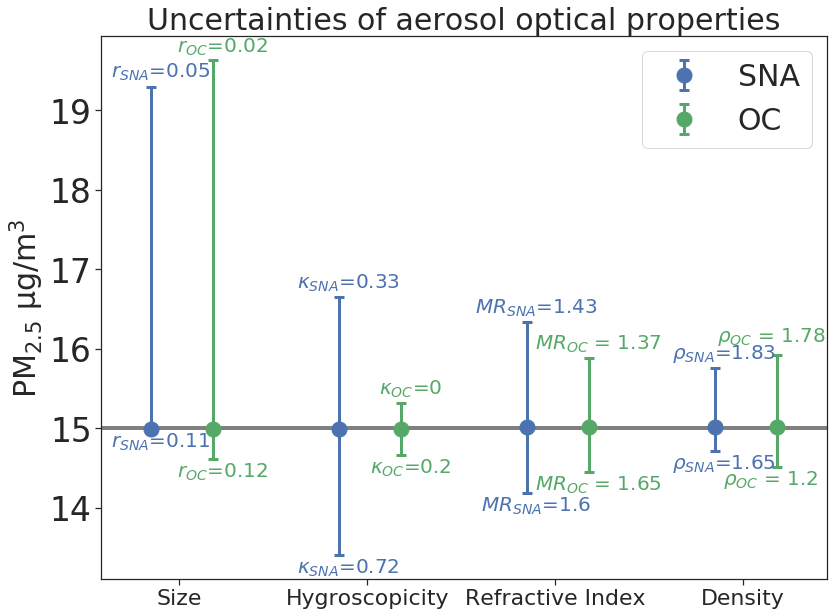

In [163]:
sns.set(color_codes=True, font_scale = 3)
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
fig, ax0 = plt.subplots(figsize=(13, 10))
lower_error = [a_i - b_i for a_i, b_i in zip(mean_arr_sulf, min_arr_sulf)]
upper_error =  [a_i - b_i for a_i, b_i in zip(max_arr_sulf, mean_arr_sulf)]
asymmetric_error = [lower_error, upper_error]
upperlimits = max_arr_sulf
lowerlimits = min_arr_sulf
x = np.arange(4)
y = mean_arr_sulf
ax0.errorbar(x, y, yerr=asymmetric_error, fmt='o',markersize =15,linewidth=3.,capsize=5, capthick=3, label="SNA",color = 'b')
labels = ['Size','Hygroscopicity','Refractive Index','Density']
# ax0.set_xticklabels(labels)
lower_error = [a_i - b_i for a_i, b_i in zip(mean_arr_oc, min_arr_oc)]
upper_error =  [a_i - b_i for a_i, b_i in zip(max_arr_oc, mean_arr_oc)]
asymmetric_error = [lower_error, upper_error]
upperlimits = max_arr_oc
lowerlimits = min_arr_oc
x = np.arange(0.33, 4.33)
y = mean_arr_oc
ax0.errorbar(x, y, yerr=asymmetric_error, fmt='o',markersize =15,linewidth=3.,capsize=5, capthick=3, label="OC",color = 'g' )
ax0.set_xticks(np.arange(0.15, 4.15))
ax0.set_xticklabels(('Size','Hygroscopicity','Refractive Index','Density'),fontsize = 22)
ax0.set_title('Uncertainties of aerosol optical properties',fontsize = 30)
ax0.set_ylabel('PM$_{2.5}$ µg/m$^{3}$',fontsize = 30)
ax0.legend(fontsize = 30)
xlim = ax0.get_xlim()
ax0.set_xlim(xlim[0]-0.1,xlim[1]+0.1)

ax0.text(0+0.05, min_arr_sulf[0]-0.3, '$r_{SNA}$=0.11',fontsize=20, ha='center',va='bottom', wrap=True,color = 'b')
ax0.text(0+0.05, max_arr_sulf[0]+0.05, '$r_{SNA}$=0.05',fontsize=20, ha='center',va='bottom', wrap=True,color = 'b')

ax0.text(0.33+0.05, min_arr_oc[0]-0.3, '$r_{OC}$=0.12',fontsize=20, ha='center',va='bottom', wrap=True,color = 'g')
ax0.text(0.33+0.05, max_arr_oc[0]+0.04, '$r_{OC}$=0.02',fontsize=20, ha='center',va='bottom', wrap=True,color = 'g')

ax0.text(1+0.05, min_arr_sulf[1]-0.3, '$\kappa_{SNA}$=0.72',fontsize=20, ha='center',va='bottom', wrap=True,color = 'b')
ax0.text(1+0.05, max_arr_sulf[1]+0.05, '$\kappa_{SNA}$=0.33',fontsize=20, ha='center',va='bottom', wrap=True,color = 'b')

ax0.text(1.33+0.05, min_arr_oc[1]-0.3, '$\kappa_{OC}$=0.2',fontsize=20, ha='center',va='bottom', wrap=True,color = 'g')
ax0.text(1.33+0.05, max_arr_oc[1]+0.05, '$\kappa_{OC}$=0',fontsize=20, ha='center',va='bottom', wrap=True,color = 'g')

ax0.text(2+0.05, min_arr_sulf[2]-0.3, '$MR_{SNA}$=1.6',fontsize=20, ha='center',va='bottom', wrap=True,color = 'b')
ax0.text(2+0.05, max_arr_sulf[2]+0.05, '$MR_{SNA}$=1.43',fontsize=20, ha='center',va='bottom', wrap=True,color = 'b')

ax0.text(2.33+0.05, min_arr_oc[2]-0.3, '$MR_{OC}$ = 1.65',fontsize=20, ha='center',va='bottom', wrap=True,color = 'g')
ax0.text(2.33+0.05, max_arr_oc[2]+0.05, '$MR_{OC}$ = 1.37',fontsize=20, ha='center',va='bottom', wrap=True,color = 'g')

ax0.text(3+0.05, min_arr_sulf[3]-0.3, '$\\rho_{SNA}$=1.65',fontsize=20, ha='center',va='bottom', wrap=True,color = 'b')
ax0.text(3+0.05, max_arr_sulf[3]+0.05, '$\\rho_{SNA}$=1.83',fontsize=20, ha='center',va='bottom', wrap=True,color = 'b')

ax0.text(3.3+0.0, min_arr_oc[3]-0.3, '$\\rho_{OC}$ = 1.2',fontsize=20, ha='center',va='bottom', wrap=False,color = 'g')
ax0.text(3.3+0.0, max_arr_oc[3]+0.09, '$\\rho_{OC}$ = 1.78',fontsize=20, ha='center',va='bottom', wrap=False,color = 'g')

ax0.axhline(15,linewidth=4, color='grey')
# ax0.tick_params(axis='x', rotation=45)